### Recruit Restaurant Visitor Forecast during Japan's Golden Week - by Heidi E. Schmidt Jun-Aug 2018 
- [Import Python libraries](#import-python-modules)
- [Centralized Python functions](#python-functions)
- [Introduce the Recruit Restaurant Data Set](#introduce-the-restaurant-dataset)
	- [Read in the Recruit Restaurant Data](#read-in-the-restaurant-data)
    - [Sample submission file](#sample-submission-file)
    - [Null Hypothesis](#null-hypothesis)
    - [Add null to avd df](#add-scratch-to-avd-df)
    - [Questions to Solve](#questions-to-solve)   
- [Exploratory data analysis (EDA)](#eda-the-data)
    - [Air Visit Data (AVD)](#air-visit-data)
    - [Air Store Info (ASI)](#air-store-info)
    - [Air Reservation Data (AR)](#air-reservation-data)
    - [Date Info](#date-info-data)
    - [Add date diffs to reservation data](#add-date-diff-to-reservations)
    - [Store Id relationships](#store-id-relation-between-air-hpg)
    - [HPG Store Info (hpgsi)](#hpg-store-info)
    - [HPG Reserve (hpgres) Data](#hpg-reservation-data)
- [Visualizing the Data](#visualizing-the-data)

- [Create test and train data](#create-test-and-train-data)

- [Linear Regression fit features](#linear-regression-fit2)

- [Fitting for a Random Forest model over LinearRegression](#fittingrf-vs-lr)

- [Playing around with np log ](#2-log-or-2logp-eval)

- [Regression eval null RMSE, RMSLE](#regression-eval)


<a id="import-python-modules"></a>
## Import the Python libraries

In [3]:
# Import Pandas for managing datasets
import pandas as pd

# Import Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

# Seaborn for plotting and styling
import seaborn as sns

# Import Numpy 
import numpy as np

# Import sklearn for fit and predictions
from sklearn import *

# Math for Kaggle RMSLE function 
import math

# For string manipulation, regular expression. and itertating 
import string, re, itertools

# Importing datetime 
from datetime import datetime

# Importing sklearn 
from sklearn import metrics
from sklearn.model_selectionsklearn.m  import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


/Users/heidischmidt/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/heidischmidt/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/heidischmidt/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the funct

<a id="python-functions"></a>
## Centralized Python functions

#### All the RMSLE 

In [338]:
# # https://www.kaggle.com/marknagelberg/rmsle-function
# import math

# #A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# def rmsle(y, y_pred):
#     assert len(y) == len(y_pred)
#     terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
#     return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [339]:
# https://gist.github.com/Tafkas/7642141
import numpy as np

def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
    
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [ ]:
def try_fitting_lr(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print('intercept', linreg.intercept_)
    print('coefficients', linreg.coef_)
    y_hat = linreg.predict(X_test)
    print('rmsle', rmsle(y_hat, y_test))
    return linreg
    
def try_fitting_rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    print('rmsle', rmsle(y_hat, y_test))
    return model

<a id="introduce-the-restaurant-dataset"></a>
## Introduce the Recruit Restaurant Data Set

##### For my final project I will be working with a data set from Recruit Holdings that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data)). 

---

* The objective of the competition- which is the problem to solve -  Predict the total number of visitors to a restaurant for future dates.

* Requirement: The data for reservations, visits, and other information from these sites to forecast future restaurant visitor totals on a given date must all be used. 

* The data was taken during January 2016 to May 2107 which includes ([Golden Week](https://www.jrailpass.com/blog/golden-week-travel-tips)) 

* Golden week means it is atypical forecasting when most folks are travelling and celebrating several holidays in a row. 

---
The means of evalution of the restaurant data is on the Root Mean Squared Logaithmic Error (RMSLE) 
where 

* n is the total number of observations
* p sub i is the prediction of visitors
* a sub i is the actual number of visitors
* log(x) is the natural logarithm of x 

---

Oddness around the data
We are not provided with the visit history for the restaurants which are only defined in the hpg system.





--- 
Restaurants will be more efficient in planning and be able to stay in business if they know how many diners to expect. The success rate for small businesses is steep in the first five years. See ([Debunking Restaurant Failure Myths](https://www.fundera.com/blog/what-percentage-of-small-businesses-fail)).

Knowing what are the reasons for success for a restaurant can be due to location, genre of food, theme of restaurant, size. Knowing how to predict if a decision is working to draw more diners in is tied to being able to forecast and iterate over the knowledge. 

In this data set from Recruit Holdings we have the benefit of their data from their review site, their reservation site, and point of sales service. 

---
Demand forecasting is a common data science application. 

Some applications to this restaurant data set could be:
* Find where to site new restauraunts and know how large of a dining room to build.
* Look at the data with respect to location of key landmarks and family grave sites as Golden Week is essentially vacation week. 

The goals of this project are to: 
* Determine if a particular food genre is more popular than another. 



<a id="read-in-the-restaurant-data"></a>
## Read In the Recruit Holdings Restaurant Data

In [6]:
# Read the Air Visit Data (avd) and set the datetime as the index.

avd = './data/air_visit_data.csv'
avd_df = pd.read_csv(avd, index_col='visit_date', parse_dates=True)

# Read the Air Visit Data (avd) as is 
avd = './data/air_visit_data.csv'
avdorig_df = pd.read_csv(avd)


# Read the Air Store Info (asi)
asi = './data/air_store_info.csv'
asi_df = pd.read_csv(asi)

# Read the Air Reserve (ar) as is as arorig_df IF needed later 
ar = './data/air_reserve.csv'
arorig_df = pd.read_csv(ar)

# Read the Date Info (keeping that long for context)
date_info = './data/date_info.csv'
date_info_df = pd.read_csv(date_info, index_col='calendar_date', parse_dates=True)

# Read the Date Info (keeping that long for context)
date_info = './data/date_info.csv'
date_info_range_df = pd.read_csv(date_info)

# Read the Store Id Relation (sid_rel)
sid_rel = './data/store_id_relation.csv'
sid_rel_df = pd.read_csv(sid_rel)

# Read the HPG Store Info 
hpgsi = './data/hpg_store_info.csv'
hpgsi_df = pd.read_csv(hpgsi)

# Read the HPG Reserve (hpgres) as is as hpgresorig_df IF needed later 
hpgres = './data/hpg_reserve.csv'
hpgresorig_df = pd.read_csv(hpgres)

#### Special Load of CSV by datetime with visits_datetime as the index 

In [7]:
## Headers of the Air Reserve (AR) file show that there 
## are 2 date time columns and need to have them parsed on load as the correct data types 
## air_store_id  visit_datetime   reserve_datetime   reserve_visitors

headers = ['air_store_id', 'visit_datetime', 'reserve_datetime', 'reserve_visitors']
dtypes = {'air_store_id': 'str', 'visit_datetime': 'str', 'reserve_datetime': 'str', 'reserve_visitors': 'str'}
parse_dates = ['visit_datetime', 'reserve_datetime']

# Looked at https://stackoverflow.com/questions/21269399/datetime-dtypes-in-pandas-read-csv for an example 
ar_df = pd.read_csv(ar, sep=',', index_col='visit_datetime', dtype=dtypes, parse_dates=[2,3])

## Headers of the HPG Reserve (HPG) file show that there 
## are 2 date time columns and need to have them parsed on load as the correct data types 
## hpg_store_id       visit_datetime     reserve_datetime reserve_visitors

headers = ['hpg_store_id', 'visit_datetime', 'reserve_datetime', 'reserve_visitors']
dtypes = {'hpg_store_id': 'str', 'visit_datetime': 'str', 'reserve_datetime': 'str', 'reserve_visitors': 'str'}
parse_dates = ['visit_datetime', 'reserve_datetime']

# Looked at https://stackoverflow.com/questions/21269399/datetime-dtypes-in-pandas-read-csv for an example 
hpgres_df = pd.read_csv(hpgres, sep=',', index_col='visit_datetime', dtype=dtypes, parse_dates=[2,3])

<a id="sample-submission-file"></a>
## Sample Submission file 

* Needs the specific date range from 2017-04-23 to 2017-05-31 

* All air id's no HPG -- first indicator of a HPG red herring 


In [258]:
sample_df = pd.read_csv('./data/sample_submission.csv')
print(sample_df.head())
print(sample_df.tail())

                                id  visitors
0  air_00a91d42b08b08d9_2017-04-23         0
1  air_00a91d42b08b08d9_2017-04-24         0
2  air_00a91d42b08b08d9_2017-04-25         0
3  air_00a91d42b08b08d9_2017-04-26         0
4  air_00a91d42b08b08d9_2017-04-27         0
                                    id  visitors
32014  air_fff68b929994bfbd_2017-05-27         0
32015  air_fff68b929994bfbd_2017-05-28         0
32016  air_fff68b929994bfbd_2017-05-29         0
32017  air_fff68b929994bfbd_2017-05-30         0
32018  air_fff68b929994bfbd_2017-05-31         0


<a id="null-hypothesis"></a>
## Null Hypothesis:  

### The Null hypothesis is that the average amount of visitors per day happen again next year this time frame.


In [8]:
avd_df['visitors'].describe()

count    252108.000000
mean         20.973761
std          16.757007
min           1.000000
25%           9.000000
50%          17.000000
75%          29.000000
max         877.000000
Name: visitors, dtype: float64

In [9]:
avd_df['visitors'].head(2)

print(np.min(avd_df['visitors']))
print(np.mean(avd_df['visitors']))
print(np.median(avd_df['visitors']))
print(np.max(avd_df['visitors']))
print(np.size(avd_df['visitors']))

1
20.973761245180636
17.0
877
252108


In [256]:
feature_df['reserve_visitors'].describe()

count    29830.000000
mean        13.879149
std         23.729264
min          1.000000
25%          4.000000
50%         10.000000
75%         18.000000
max       2241.000000
Name: reserve_visitors, dtype: float64

In [255]:
import numpy as np
print(np.min(feature_df['reserve_visitors']))
print(np.mean(feature_df['reserve_visitors']))
print(np.median(feature_df['reserve_visitors']))
print(np.max(feature_df['reserve_visitors']))
print(np.size(feature_df['reserve_visitors']))

1
13.879148508213207
10.0
2241
29830


<a id="questions-to-solve"></a>
## Question(s) to solve:  

* What is the average Y (total visitors) by genre?
* What is the average Y (total visitors) if holiday or not? 
* What is the average Y (total visitors) by day of week?

---

### Other questions 

* What is the average Y (total visitors) by location? 
* What location had the most visitors by genre? 
* Which days (holiday or day of week) had no visitors? 
* What days are most frequented?
* Are those days holidays (national, school vacation, or other)? -- I.e. Golden week and do they exclude days closed ? 
* When is a reservation used and for how many people?
* What customer segments can be derived from genre & visiting behavior?

## <a id="eda-the-data"></a>
## Exploratory Data Analysis (EDA) 

* The use of simple tools, like graphing and summary statistics, to better understand the data. 

* Review plots and summarize and note obvious temporal structures, like trends seasonality, anomalies like missing data, corruption, and outliers, and any other structures that may impact forecasting.


---

## Working through the EDA 

Those are the individual files:

* air_visit_data.csv: historical visit data for the air restaurants. This is essentially the main training data set.

* sample_submission.csv: serves as the validation set. The id is formed by combining the air id with the visit date.

Initial ideas on columns 

#### date, total_visitors, locations, system(yelp or reservation) <-- this not needed 

Layout columns suggestions from John Mercer 

* Instead of total visitors -- take the log of total_visitors and add it as a new column and compare it to total_visitors -- I was not sure what to do with it if I added it so I skipped it. 

*** Look at what they want for a submission file and see if you have to translate the log back for total visitors
*** May need to be computed, but not used in the final submission file - Can't tell 

What is the response?
Y response is total visitors

What are the features?
* day of week 
* is holiday (0 or 1)
* genre (i.e. italian, sweets) 
* location ( ward, chome, ku ) 

Different total visitors based on genre? A: Yes. 

Be careful that location may have a one to one mapping to genre. A: Did not get to this. 

EDA
* What is the average Y (total visitors) by genre?
* What is the average Y (total visitors) by day of week?
* What is the average Y (total visitors) holiday or not?

* The features spiralled a bit and had me very worked up on permutations and fit 


## Lessons Learned in EDA and Visualizing the Data

* There is never enough time 

* Adding in too many dummies and making me a dummy as result. I.e. Too much and I couldn't sort properly - nor could the notebook. It hung and crashed and it took me a day and a half to get back to this point. And that is where I left it. 

* Trying Random Forest helped me see the data in a ranking way and made the combinations on the fly for me that would have left me feeling like I addressed it halfway and piecemeal. 

* It would have been best if I had gone through all the git hub links for final project first week of class and realized that I needed to be doing a little each week. SMH.

* Choosing a data set in the last month was nuts of me to do. Ob sit. 

* Having internet go out 2 times for 10 days total in the last 2 weeks was about to have me cry and pull out all my hair. 

* Beautiful AI is awesome and it was the easiest part of the process. Thanks John! 

* The discoveries were not all for naught. They just aren't as quickly as deep as others. I learned a bunch.  


### <a id="air-visit-data"></a>
### Air Visit Data (AVD) 

This file contains historical visit data for the air restaurants.

* air_store_id
* visit_date - the date
* visitors - the number of visitors to the restaurant on the date

In [11]:
# Air Visit Data (avd) 
print('The AVD data types are: \n')
print(avd_df.dtypes)
print('\n')
print('The Air Visit Data index is based around time from January 2016 to April 2017: \n')
print(avd_df.index)
print('\n')
print('The AVD data frame info shows no nulls because all the counts across rows are the same: \n')
print(avd_df.info())
print('\n')
print('----------- Air Visit Data First rows  \n')
print(avd_df.head(3))
print('\n')
print('----------- Air Visit Data Last rows  \n')
print(avd_df.tail(3))

The AVD data types are: 

air_store_id    object
visitors         int64
dtype: object


The Air Visit Data index is based around time from January 2016 to April 2017: 

DatetimeIndex(['2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-18', '2016-01-19', '2016-01-20', '2016-01-21',
               '2016-01-22', '2016-01-23',
               ...
               '2017-04-11', '2017-04-12', '2017-04-13', '2017-04-14',
               '2017-04-15', '2017-04-18', '2017-04-19', '2017-04-20',
               '2017-04-21', '2017-04-22'],
              dtype='datetime64[ns]', name='visit_date', length=252108, freq=None)


The AVD data frame info shows no nulls because all the counts across rows are the same: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252108 entries, 2016-01-13 to 2017-04-22
Data columns (total 2 columns):
air_store_id    252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.8+ MB
None


------

In [12]:
#### Adding the month, year, and other data for avd_df 
avd_df['year'] = avd_df.index.year
avd_df['month'] = avd_df.index.month
avd_df['dow'] = avd_df.index.dayofweek

In [13]:
avd_df['dow'].value_counts()

4    40351
5    39262
3    37996
2    36811
1    36015
0    31682
6    29991
Name: dow, dtype: int64

In [14]:
avd_df['month'].value_counts()

3     30570
2     27415
1     27020
4     23859
12    21515
10    21466
7     21427
11    20924
9     20829
8     20675
6      8247
5      8161
Name: month, dtype: int64

In [15]:
avd_df['year'].value_counts()

2016    174535
2017     77573
Name: year, dtype: int64

#### Find unique air_store_id and hpg_store_id in the reservation data files 

In [16]:
len(hpgresorig_df['hpg_store_id'].unique())

13325

In [17]:
len(ar_df['air_store_id'].unique())

314

In [257]:
len(feature_df['id'].unique())

314

In [18]:
len(sid_rel_df['air_store_id'].unique())

150

In [19]:
len(sid_rel_df['hpg_store_id'].unique())

150

#### Unique air stores in historical air store visit data 

In [20]:
airstore_uniq = avd_df['air_store_id'].unique()
print(len(airstore_uniq))
print(len(avd_df['air_store_id']))

829
252108


In [21]:
avd_df.head(2)

,air_store_id,visitors,year,month,dow
visit_date,,,,,
2016-01-13,air_ba937bf13d40fb24,25,2016,1,2
2016-01-14,air_ba937bf13d40fb24,32,2016,1,3


In [22]:
### Save my work FOr Air Visit Data (avd) intermittantly to CSV 

avd_df.to_csv('./restaurant-forecast-clean-do-over.csv')

### <a id="add-scratch-to-avd-df"></a>
### Test add null hypothesis to avd df - historical data 

Making a scratch place to work with data to plug in the null hypothesis 

Did not end up using it as it calculated for what was there, not predict the visitors. 
So that way looked like it would end up over fitting any model. 


In [23]:
avd_df.groupby(['air_store_id','dow'])
scratch = avd_df.groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
scratch.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations']

In [24]:
scratch.head(2)

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1,22.457143,19.0,47,35
1,air_00a91d42b08b08d9,1,1,24.350000,24.5,43,40


In [25]:
air_stores = pd.concat([pd.DataFrame({'air_store_id': airstore_uniq, 'dow': [i]*len(airstore_uniq)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [26]:
air_stores = pd.merge(air_stores, scratch, how='left', on=['air_store_id','dow']) 
air_stores.head(3)

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_ba937bf13d40fb24,0,2.0,13.754386,12.0,34.0,57.0
1,air_25e9888d30b386df,0,1.0,1.666667,2.0,2.0,3.0
2,air_8e4360a64dbd4c50,0,2.0,24.428571,23.5,47.0,42.0


In [27]:
air_stores.shape

(5803, 7)

## Concatentate reservation data after adding system to the data frame 

For HPG this is absolutely NOT necessary. It's got so many Nulls you could drive a truck through it. 

This was a first attempt.
The final attempt was the making of the together df.

Lessons learned from that were that hpg doesn't have entries in the store id relational data.

Trying to narrow down the data set from that day and put them all into air id's was not possible. Too much missing data. 

Instead of trying to get 2 million from hpg I punted and rolled with the air reservation data. 


Steps 

1) add the system column 

2) rename the air_store_id hpg_store_id

3) concat both reservation data sets 

In [28]:
arorig_df['system'] = 'air'

In [29]:
hpgresorig_df['system'] = 'hpg'

In [30]:
arorig_df.columns 

Index(['air_store_id', 'visit_datetime', 'reserve_datetime',
       'reserve_visitors', 'system'],
      dtype='object')

In [31]:
hpgresorig_df.columns

Index(['hpg_store_id', 'visit_datetime', 'reserve_datetime',
       'reserve_visitors', 'system'],
      dtype='object')

In [32]:
# without inplace it renames on the fly and is not permanent 
hpgresorig_df.rename(columns={'hpg_store_id':'store_id'},inplace=True)

In [33]:
arorig_df.rename(columns={'air_store_id':'store_id'},inplace=True)

In [34]:
hpgresorig_df.head(1)

,store_id,visit_datetime,reserve_datetime,reserve_visitors,system
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,hpg


In [35]:
arorig_df.head(1)

,store_id,visit_datetime,reserve_datetime,reserve_visitors,system
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,air


In [36]:
merged_res = pd.concat([arorig_df, hpgresorig_df], names=['store_id','visit_datetime','reserve_datetime','reserve_visitors','system'])

# example -- pd.concat([s1, s2], keys=['s1', 's2'], names=['Series name', 'Row ID'])
# names=['store_id','visit_datetime','reserve_datetime','reserve_visitors','system']

In [43]:
merged_res.shape

#   92379 air_reserve.csv
# 2000321 hpg_reserve.csv
#  32020  sample_submission.csv  file has only 822 unique air store id's which is > 151 in store rel

# 2092698 merged_res df 

(2092698, 5)

In [44]:
merged_res.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors,system
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,air
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,air
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,air
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,air
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,air


<a id="create-test-and-train-data"></a>
## Create test and train data

Making the training file feature_df



In [53]:
# Set the index so that we can make all the values be air as the submission sample is all air 
# And it looks like other kaggle submission samples are all air so we reverse engineer and that's that.
hpg_to_air = sid_rel_df.set_index('hpg_store_id')
hpg_to_air.head()

,air_store_id
hpg_store_id,
hpg_4bc649e72e2a239a,air_63b13c56b7201bd9
hpg_c34b496d0305a809,air_a24bf50c3e90d583
hpg_cd8ae0d9bbd58ff9,air_c7f78b4f3cba33ff
hpg_de24ea49dc25d6b8,air_947eb2cae4f3e8f2
hpg_653238a84804d8e7,air_965b2e0cf4119003


### Use merged_res  and roll up the visitors into date (YYYY-MM-DD)

In [115]:
# Do a join to get the data together and 
# joined based on the information in the store relation info for air for every correlating hpg store id 
together = merged_res.set_index('store_id').join(hpg_to_air)

# Focus only on the air and deal with the nulls introduced by air id's not in the store rel of 150 records 
still_need_air = together.air_store_id.isnull() & together.index.str.startswith('air')

# Locate in the still_need_air the air store id and set the index on it
together.loc[still_need_air, 'air_store_id'] = together.index[still_need_air]

# Get the id to be in submission format to save time later
together = together.rename(columns={'air_store_id': 'id'})

# Peculiar leftovers that still had hpg showing up - needed the mask 
good_mask = together.index.str.startswith('air')
together = together[good_mask]

# The numbers don't add up and I think the hpg got dropped \n",
# Name: id, Length: 92378, dtype: object\n",

#   92379 air_reserve.csv\n",
# 2000321 hpg_reserve.csv\n",
#  32020  sample_submission.csv  file has only 822 unique air store id's which is > 151 in store rel\n",

# 2092698 merged_res df "

In [116]:
together.head()

,visit_datetime,reserve_datetime,reserve_visitors,system,id
air_00a91d42b08b08d9,2016-10-31 20:00:00,2016-10-31 16:00:00,2,air,air_00a91d42b08b08d9
air_00a91d42b08b08d9,2016-12-05 19:00:00,2016-12-01 15:00:00,9,air,air_00a91d42b08b08d9
air_00a91d42b08b08d9,2016-12-14 19:00:00,2016-12-08 10:00:00,18,air,air_00a91d42b08b08d9
air_00a91d42b08b08d9,2016-12-17 19:00:00,2016-12-11 16:00:00,2,air,air_00a91d42b08b08d9
air_00a91d42b08b08d9,2016-12-20 20:00:00,2016-12-18 17:00:00,4,air,air_00a91d42b08b08d9


In [117]:
together.shape

(92378, 5)

### Initial creation of feature_df from together data frame 

Going back to first principles that the training data is the source for test and train. 

The other data set has the same date ranges and air id's. 

The sample submission file is ONLY for Golden Week itself. 

In [118]:
# Take the date and split it along space character
# to then take the YYYY-MM-DD as position zero and set that as date column
together['date'] = together['visit_datetime'].str.split(' ').map(lambda x: x[0])

# If the thing being asserted does not eval to true it would then cause a stack trace
assert together.id.notnull().all()

# Another group by to to get the sum of visitors by day because we need to roll it up like the submission file 
# This becomes our foundation file and the building block
# Though this takes our data set of 92k and rolls it up only into 29K -- wow 
feature_df = together.groupby(['id', 'date']).reserve_visitors.sum().reset_index()
feature_df.head()

# feature_df has 1,378,626 records which is less than merged_res and more than air \n",
#   92379 air_reserve.csv\n",
# 2000321 hpg_reserve.csv\n",
#  32020  sample_submission.csv  file has only 822 unique air store id's which is > 151 in store rel\n",

# 2092698 merged_res df "

,id,date,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,2
1,air_00a91d42b08b08d9,2016-12-05,9
2,air_00a91d42b08b08d9,2016-12-14,18
3,air_00a91d42b08b08d9,2016-12-17,2
4,air_00a91d42b08b08d9,2016-12-20,4


### Notes 

#### Store ID itself --  adding it to the feature df  is Not unique enough - would make it too wide

#### Creating a map of location by ward, chome, ku as numerics and then what to do with that... -- did not have time 

Features from dummy variables already becomes a hug problem for me to iterate with below

Doing the correlations piecewise as I built it let me see a bit more and rule out some of the incorrect correlations.

Lessons learned: have more time to write functions to loop through each piece

len(asi_df['air_store_id'].unique())
"829 "

### Adding in day of week, month, year

In [119]:
feature_df.date = pd.to_datetime(feature_df.date)
feature_df.date.dt.dayofweek.head()
feature_df = feature_df.join(pd.get_dummies(feature_df.date.dt.dayofweek).rename(columns=lambda x: 'dow{}'.format(x)))

In [120]:
feature_df = feature_df.join(pd.get_dummies(feature_df.date.dt.month).rename(columns=lambda x: 'month{}'.format(x)))

In [121]:
feature_df = feature_df.join(pd.get_dummies(feature_df.date.dt.year).rename(columns=lambda x: 'year{}'.format(x)))

In [122]:
feature_df.shape

(29830, 24)

In [269]:
holiday_dummies = pd.get_dummies(date_info_df.holiday_flg, prefix='hol')
holiday_dummies.head()
# Print five random rows.
holiday_dummies.sample(n=5, random_state=10)

,hol_0,hol_1
calendar_date,,
2016-10-20,1,0
2016-12-02,1,0
2017-05-23,1,0
2016-12-17,1,0
2016-06-13,1,0


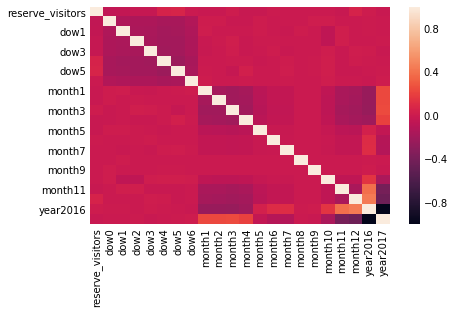

In [123]:
sns.heatmap(feature_df.corr())

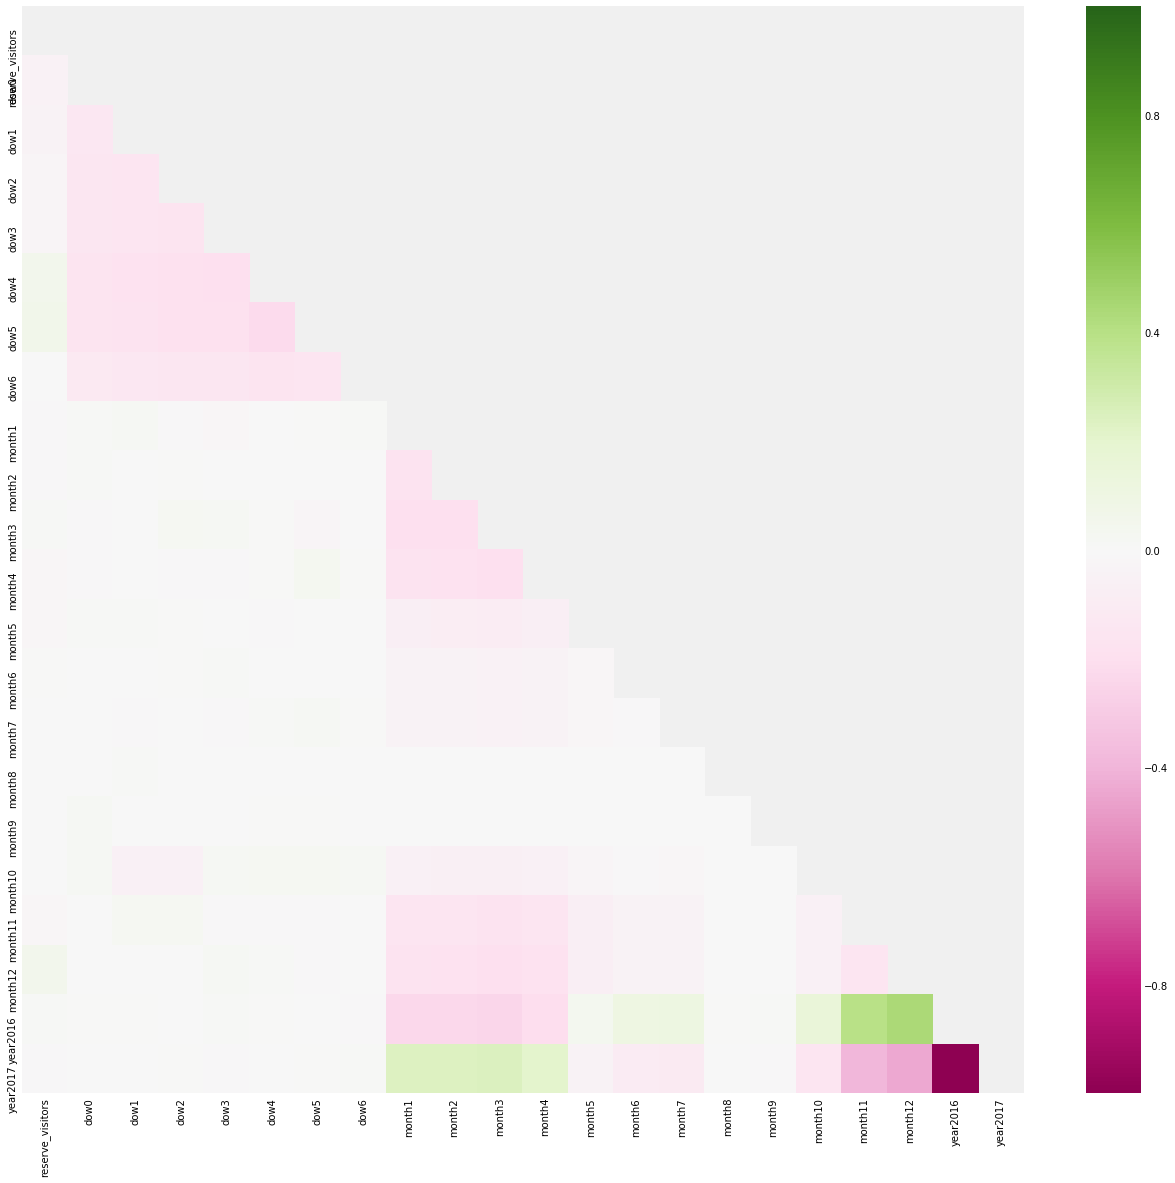

In [124]:
# Make the correllation a variable
corrs = feature_df.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(20,20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask, cmap='PiYG')

### Feature Data Frame - Adding in the area and location

In [125]:
# test_merge = pd.merge(feature_df, sid_rel_df, how='left', on=['air_store_id'])
feature_df = pd.merge(feature_df, asi_df,  how='left', left_on=['id'], right_on = ['air_store_id'])

feature_df['air_genre_name'] = feature_df['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
feature_df['air_genre_name'] = feature_df['air_genre_name'].map(lambda x: str(str(x).replace(' ','-')))

feature_df['ken'] = feature_df['air_area_name'].str.split(' ').map(lambda x: x[0])
feature_df['ku'] = feature_df['air_area_name'].str.split(' ').map(lambda x: x[1])
feature_df['chome'] = feature_df['air_area_name'].str.split(' ').map(lambda x: x[2])


In [126]:
# feature_df.drop(['air_store_id_x','air_genre_name_x','air_area_name_x','air_store_id_y','air_genre_name_y','air_area_name_y','latitude','longitude'], axis=1, inplace=True)
# 'air_store_id_x','air_genre_name_x','air_area_name_x','air_store_id_y','air_genre_name_y','air_area_name_y','latitude','longitude'

feature_df = feature_df.join(pd.get_dummies(feature_df.ken).rename(columns=lambda x: '{}'.format(x)))
feature_df = feature_df.join(pd.get_dummies(feature_df.air_genre_name).rename(columns=lambda x: 'genre-{}'.format(x)))

In [127]:
feature_df.columns

Index(['id', 'date', 'reserve_visitors', 'dow0', 'dow1', 'dow2', 'dow3',
       'dow4', 'dow5', 'dow6', 'month1', 'month2', 'month3', 'month4',
       'month5', 'month6', 'month7', 'month8', 'month9', 'month10', 'month11',
       'month12', 'year2016', 'year2017', 'air_store_id', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'ken', 'ku', 'chome',
       'Fukuoka-ken', 'Hiroshima-ken', 'Hokkaidō', 'Hyōgo-ken', 'Miyagi-ken',
       'Niigata-ken', 'Shizuoka-ken', 'Tōkyō-to', 'Ōsaka-fu', 'genre-Asian',
       'genre-Bar-Cocktail', 'genre-Cafe-Sweets', 'genre-Creative-cuisine',
       'genre-Dining-bar', 'genre-International-cuisine',
       'genre-Italian-French', 'genre-Izakaya', 'genre-Japanese-food',
       'genre-Karaoke-Party', 'genre-Okonomiyaki-Monja-Teppanyaki',
       'genre-Other', 'genre-Western-food', 'genre-Yakiniku-Korean-food'],
      dtype='object')

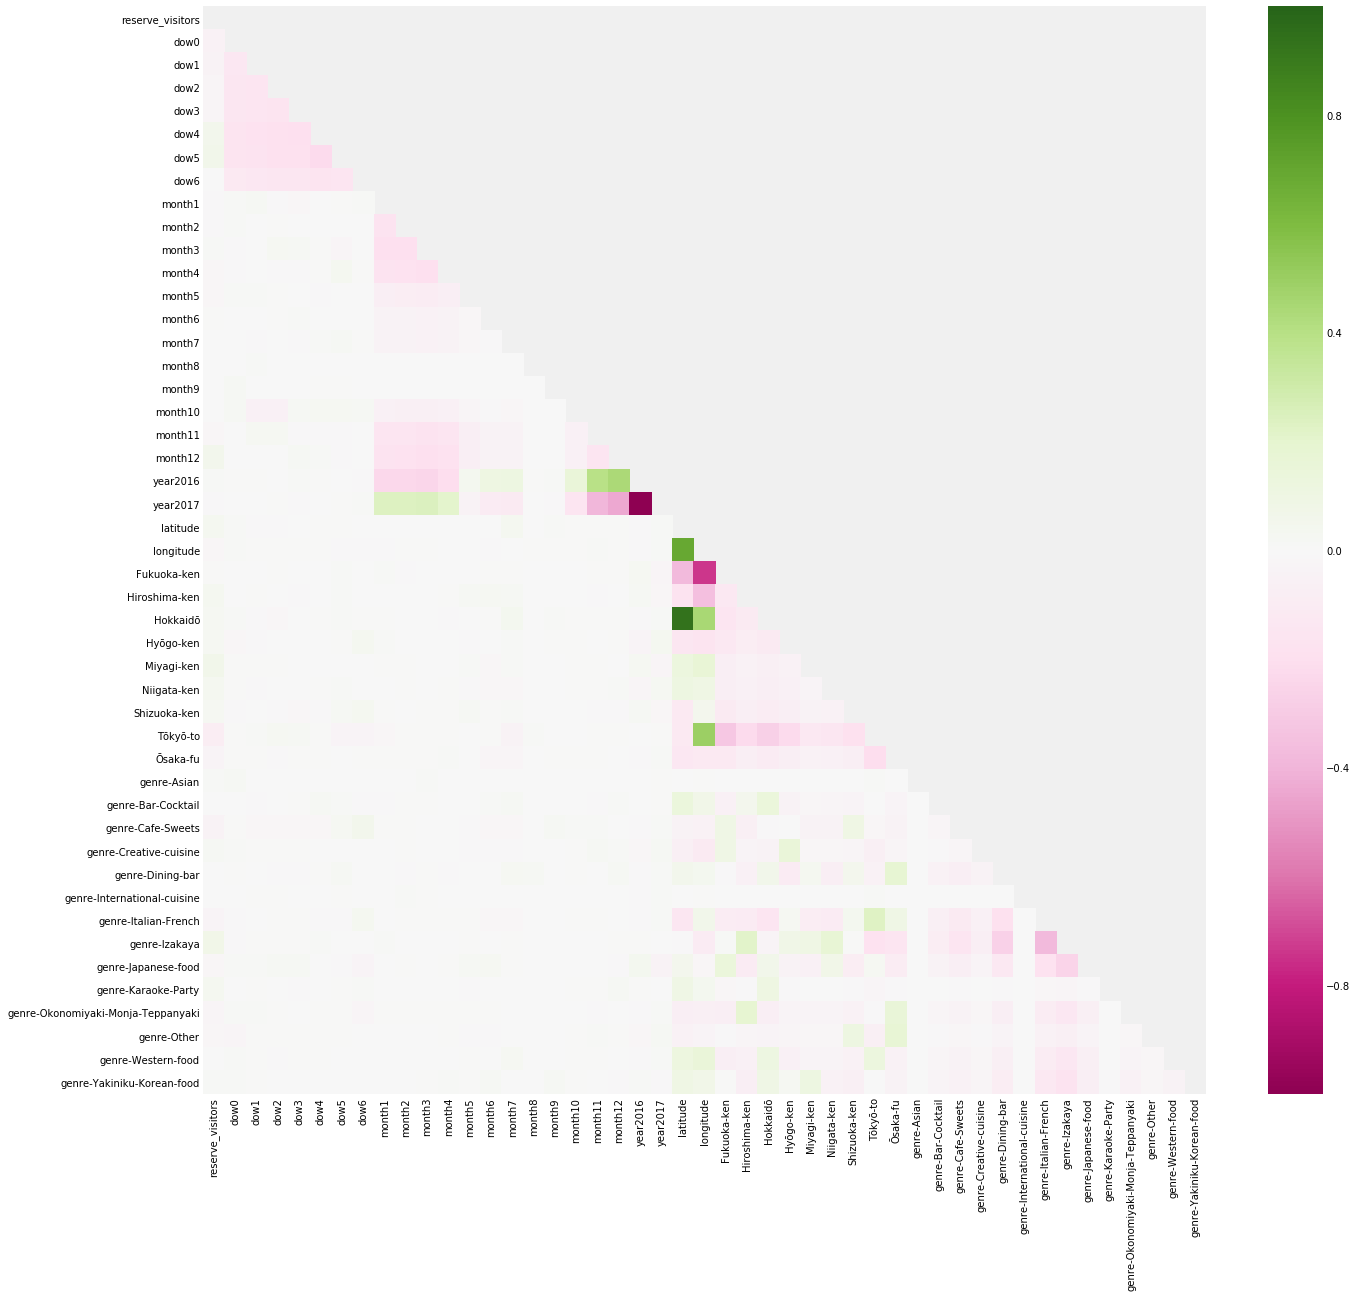

In [142]:
# Make the correllation a variable
corrs = feature_df.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(20,20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask, cmap='PiYG')

In [560]:
### Save the feature file just in case
feature_df.to_csv('./feature_df_backup.csv')
together.to_csv('./together_backup.csv')

### HPG rabbit hole - 

Started below and moved on. 

Too many gaps in the data as there were not air id's for every hpg id 

In [316]:
together.visit_datetime = pd.to_datetime(together.visit_datetime)
print('Together datatypes: \n', together.dtypes)
print('\n')
print('Together value counts: \n', together.system.value_counts())
# there should be two systems -- air and hpg from the merge and they are removed\n",
# there are only 92378 records which only map to air \n",

#   92379 air_reserve.csv\n",
# 2000321 hpg_reserve.csv\n",
#  32020  sample_submission.csv  file has only 822 unique air store id's which is > 151 in store rel\n",

# 2092698 merged_res df "

Together datatypes: 
 visit_datetime      datetime64[ns]
reserve_datetime            object
reserve_visitors             int64
system                      object
id                          object
date                        object
is_air                       int64
dow0                         uint8
dow1                         uint8
dow2                         uint8
dow3                         uint8
dow4                         uint8
dow5                         uint8
dow6                         uint8
dtype: object


Together value counts: 
 air    67691644
Name: system, dtype: int64


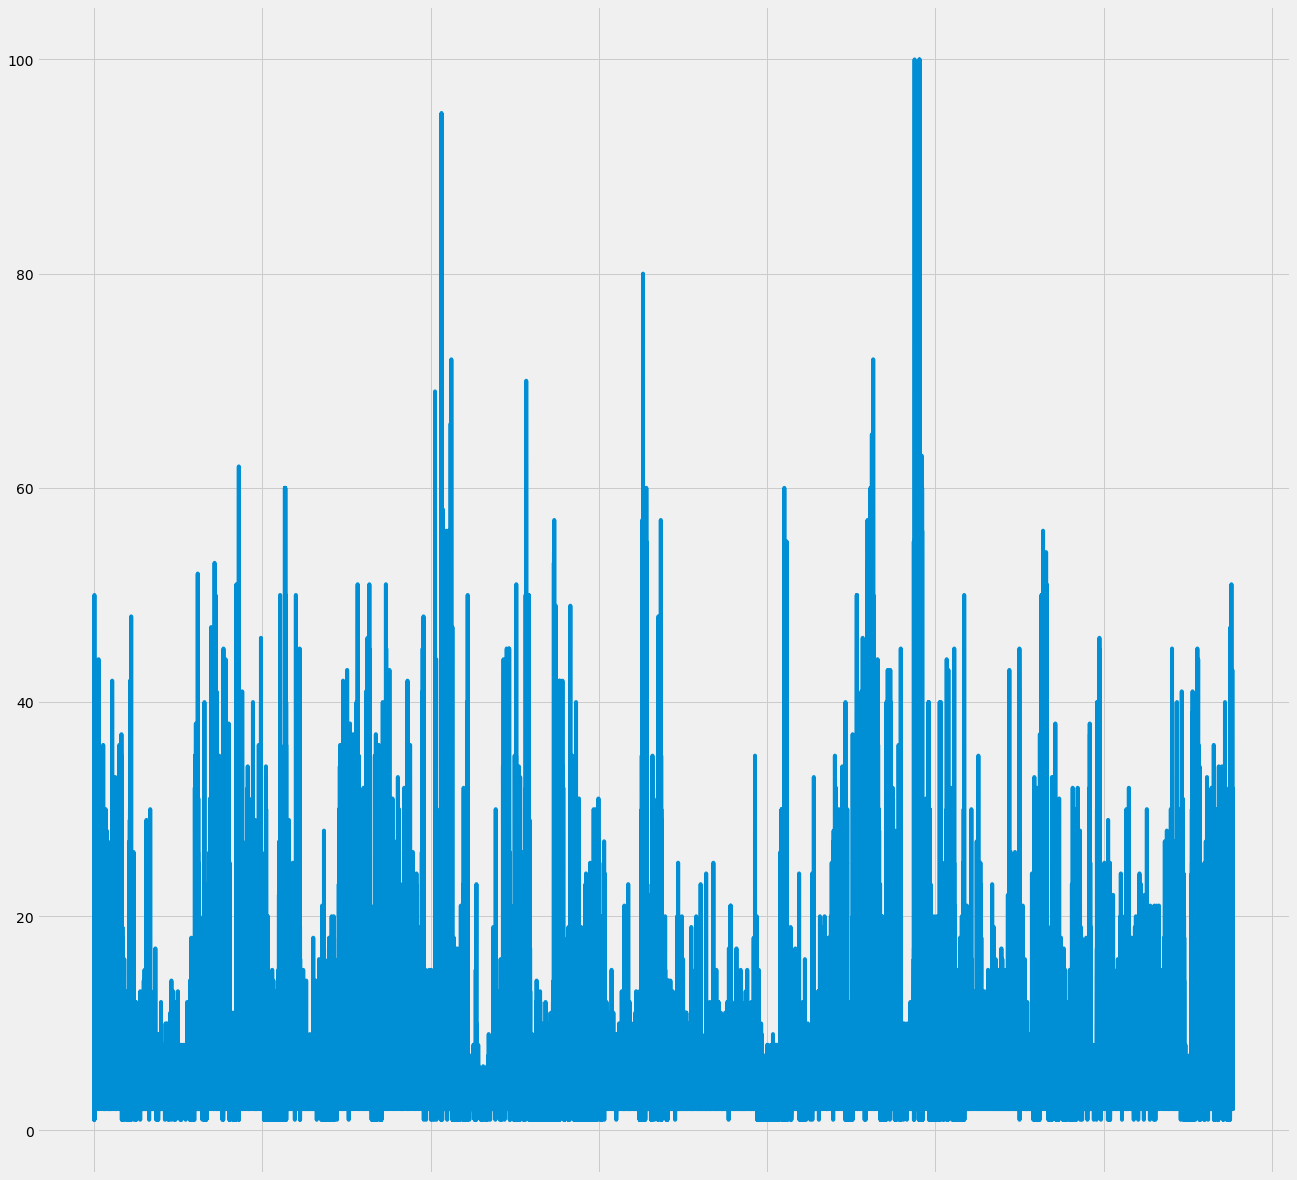

In [319]:
# Basic plot as is. 
# This doesn't work to accurately give scale. Plot further down using loglog on ax does 
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")
together.reserve_visitors.plot(figsize=(20,20));


In [131]:
together['is_air'] = (together.system == 'air').astype(int)
print(together.columns)
print('\n')
print('Together is_air flag counts: \n', together.is_air.value_counts())
# there should be both hpg and air 

Index(['visit_datetime', 'reserve_datetime', 'reserve_visitors', 'system',
       'id', 'date', 'is_air'],
      dtype='object')


Together is_air flag counts: 
 1    92378
Name: is_air, dtype: int64


In [132]:
together.visit_datetime.dt.dayofweek.head()
together.visit_datetime = pd.to_datetime(together.visit_datetime)
together = together.join(pd.get_dummies(together.visit_datetime.dt.dayofweek)
                         .rename(columns=lambda x: 'dow{}'.format(x)))

In [133]:
# sns.heatmap(together.corr())
# Not enough to correllate off of though it has more 2/3rds more data than the feature_df"
together.shape
#   "(67691644, 13)"

(67691644, 14)

In [134]:
y = together.reserve_visitors.values

feature_cols = ['is_air'] + [c for c in together.columns if c.startswith('dow')]
X = together[feature_cols]

lr = linear_model.LinearRegression()
lr.fit(X, y)
lr.intercept_, lr.coef_
# intercept always assumes 5 visitors 
# if is_air then subtract half a visitor (not helpful) and the numbers are way too off.. 
# that lead me to log

# This intercept is way off which got worse when other features added (like genre) 

(4203115.078741941,
 array([       0.        , -4203110.93123275, -4203110.92926553,
        -4203110.87913018, -4203110.85065311, -4203110.81740307,
        -4203110.81117174, -4203111.07197367]))

### Linear Regression for each feature combo on Feature Data Frame 

From the correllation(s) above on the feature_df data frame I can tell that

* the best months in 2016 were possibly 6-7 & definately 11-12 (Oct - Dec)
* the best months in 2017 were 1-4 and possibly 5 (Jan - May)

The best days in week are 4 and 5 (Thurs and Friday)

0 = Sun, 1 = Mon, 2 = Tues, 3 = Weds, 4 = Thurs, 5 = Fri, 6 = Sat

Hokkaido has the most correlation by longitude and latitude
(which should be combined into one thing to be accurate -- outside my current skills)

The best correlation for cities for certain types of food

* Tokyo -- Dining Bar, French-Italian, Western
* Fukuoka -- Cafe Sweets
* Osaka -- Teppanyaki, Other
* Hiroshima -- Izakaya, Teppenyaki



In [135]:
feature_df.columns

Index(['id', 'date', 'reserve_visitors', 'dow0', 'dow1', 'dow2', 'dow3',
       'dow4', 'dow5', 'dow6', 'month1', 'month2', 'month3', 'month4',
       'month5', 'month6', 'month7', 'month8', 'month9', 'month10', 'month11',
       'month12', 'year2016', 'year2017', 'air_store_id', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'ken', 'ku', 'chome',
       'Fukuoka-ken', 'Hiroshima-ken', 'Hokkaidō', 'Hyōgo-ken', 'Miyagi-ken',
       'Niigata-ken', 'Shizuoka-ken', 'Tōkyō-to', 'Ōsaka-fu', 'genre-Asian',
       'genre-Bar-Cocktail', 'genre-Cafe-Sweets', 'genre-Creative-cuisine',
       'genre-Dining-bar', 'genre-International-cuisine',
       'genre-Italian-French', 'genre-Izakaya', 'genre-Japanese-food',
       'genre-Karaoke-Party', 'genre-Okonomiyaki-Monja-Teppanyaki',
       'genre-Other', 'genre-Western-food', 'genre-Yakiniku-Korean-food'],
      dtype='object')

In [136]:
stuff = ['dow5', 'month4','month5','month11', 'month12', 
         'Fukuoka-ken', 'Hiroshima-ken', 'Hokkaidō', 'Tōkyō-to', 'Ōsaka-fu',
         'genre-Cafe-Sweets','genre-Dining-bar', 'genre-Italian-French', 'genre-Izakaya',
         'genre-Okonomiyaki-Monja-Teppanyaki','genre-Other', 'genre-Western-food']

# stuff = ['dow5', 'dow6', 'month1', 'month2', 'month3', 'month4','month5','month11', 'month12', 
#        'year2016', 'year2017', 'Fukuoka-ken', 'Hiroshima-ken', 'Hokkaidō', 'Tōkyō-to', 'Ōsaka-fu',
#         'genre-Bar-Cocktail', 'genre-Cafe-Sweets','genre-Dining-bar', 'genre-Italian-French', 'genre-Izakaya',
#         'genre-Okonomiyaki-Monja-Teppanyaki','genre-Other', 'genre-Western-food']


len(stuff)

17

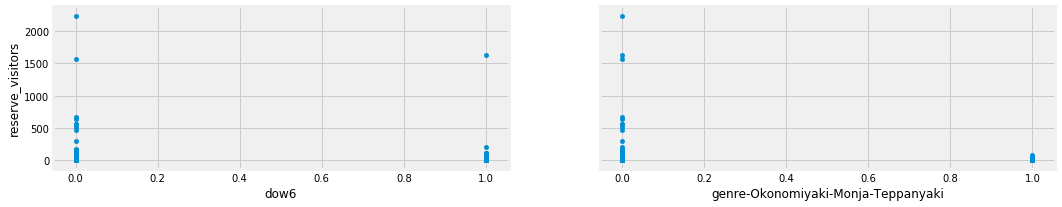

In [103]:
feature_cols1 = ['dow6', 'genre-Okonomiyaki-Monja-Teppanyaki']

# Multiple scatterplots in Pandas\n",
fig, axs = plt.subplots(1, len(feature_cols1), sharey=True)
for index, feature in enumerate(feature_cols1):
    feature_df.plot(kind='scatter', x=feature, y='reserve_visitors', ax=axs[index], figsize=(16, 3))


/Users/heidischmidt/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


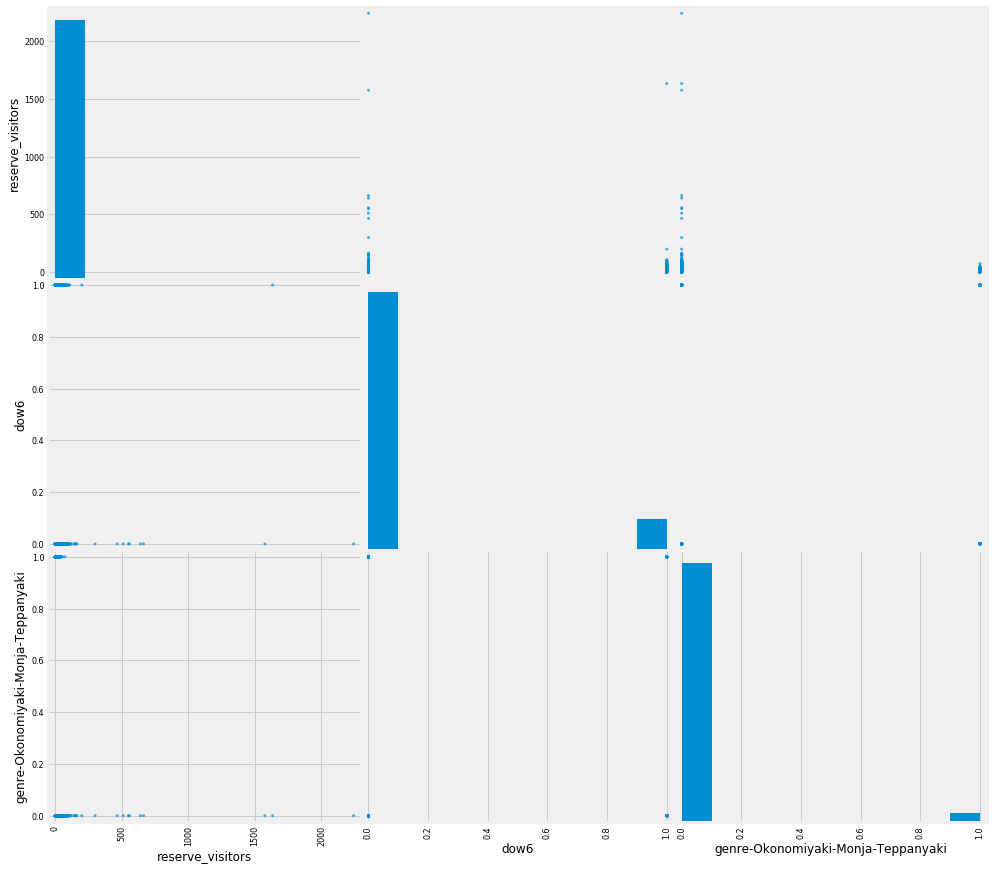

In [147]:
pd.tools.plotting.scatter_matrix(feature_df[['reserve_visitors'] + feature_cols1], figsize=(15, 15), alpha=0.7);

### Add the holiday flag to feature data frame 

In [511]:
feature_df = pd.read_csv('./feature_df_backup.csv')

In [513]:
# add holiday col to feature_df 
# print(date_info_df.head())
# print(feature_df.head())
# feature_df.columns

date_info = './data/date_info.csv'
date_info_df = pd.read_csv(date_info)
date_info_df.head()

# Make it same column_name as feature data frame 
date_info_df = date_info_df.rename(columns={'calendar_date':'date'})

feature_df.date = pd.to_datetime(feature_df.date)
feature_df = feature_df.join(date_info_df.holiday_flg)



In [526]:
feature_df = feature_df.join(pd.get_dummies(feature_df.holiday_flg).rename(columns=lambda x: 'is_hol{}'.format(x)))


In [527]:
feature_df.columns

Index(['Unnamed: 0', 'id', 'date', 'reserve_visitors', 'dow0', 'dow1', 'dow2',
       'dow3', 'dow4', 'dow5', 'dow6', 'month1', 'month2', 'month3', 'month4',
       'month5', 'month6', 'month7', 'month8', 'month9', 'month10', 'month11',
       'month12', 'year2016', 'year2017', 'air_store_id', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'ken', 'ku', 'chome',
       'Fukuoka-ken', 'Hiroshima-ken', 'Hokkaidō', 'Hyōgo-ken', 'Miyagi-ken',
       'Niigata-ken', 'Shizuoka-ken', 'Tōkyō-to', 'Ōsaka-fu', 'genre-Asian',
       'genre-Bar-Cocktail', 'genre-Cafe-Sweets', 'genre-Creative-cuisine',
       'genre-Dining-bar', 'genre-International-cuisine',
       'genre-Italian-French', 'genre-Izakaya', 'genre-Japanese-food',
       'genre-Karaoke-Party', 'genre-Okonomiyaki-Monja-Teppanyaki',
       'genre-Other', 'genre-Western-food', 'genre-Yakiniku-Korean-food',
       'holiday_flg', 'is_hol0.0', 'is_hol1.0'],
      dtype='object')

In [ ]:
feature_df.shape

In [ ]:
# feature_df.drop(['Unamed','holiday_flg'], axis=1, inplace=True)

In [528]:
feature_df.holiday_flg.value_counts()

0.0    482
1.0     35
Name: holiday_flg, dtype: int64

In [529]:
feature_df.dtypes

Unnamed: 0                                     int64
id                                            object
date                                  datetime64[ns]
reserve_visitors                               int64
dow0                                           int64
dow1                                           int64
dow2                                           int64
dow3                                           int64
dow4                                           int64
dow5                                           int64
dow6                                           int64
month1                                         int64
month2                                         int64
month3                                         int64
month4                                         int64
month5                                         int64
month6                                         int64
month7                                         int64
month8                                        

## <a id="fittingrf-vs-lr"></a>
## Fitting for a Random Forest model over LinearRegression 

### Making LR for just dow 

In [333]:
# Linear Regression 
#  
# Import, instantiate, fit for LR 
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
# Create X and y.\n",
feature_cols = ['dow' + str(x) for x in range(1, 7)]

X = feature_df[feature_cols]
y = feature_df.reserve_visitors

X.head()

# look at encoding of turning numerics into non numerics
# the intercepts fight each other because the 1 in column throws off intercept 
# if you don't know the number of visitors that intercept is the best guess overall 

,dow1,dow2,dow3,dow4,dow5,dow6
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,1,0,0,0,0
3,0,0,0,0,1,0
4,1,0,0,0,0,0


In [341]:
# Fit the LR model on day of week 
# Shows that the base visitors are 10.6 and for each day of week to expect as an increase to the base 
# The RMSLE is close to 0 which is a good sign. 
# Instantiate and fit.

linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)  
print(linreg.coef_)        

y_hat = linreg.predict(X)
print('rmsle', rmsle(y_hat, y))

10.695432977461437
[0.45439824 1.76670988 1.78465856 6.04326503 6.68509632 2.86533793]
rmsle 0.864877757771524


### Linear Regression on all feature columns 

The intercept is insane for all features and it really had me going 

In [548]:
# Fit the LR model all the columns and the numbers are crazy when they should be 
# more uniform 
# The RMSLE though oddly is still near 0.84

# Instantiate and fit.

linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)   
print(linreg.coef_)       
                          
y_hat = linreg.predict(X)
print('rmsle', rmsle(y_hat, y))

-22776421006013.047
[ 3.00753762e+13  3.00753762e+13  3.00753762e+13  3.00753762e+13
  3.00753762e+13  3.00753762e+13  3.00753762e+13 -7.29895521e+12
 -7.29895521e+12 -7.29895521e+12 -7.29895521e+12 -7.29895521e+12
 -7.29895521e+12 -7.29895521e+12 -7.29895521e+12 -7.29895521e+12
 -7.29895521e+12 -7.29895521e+12 -7.29895521e+12 -7.29895521e+12
 -7.29895521e+12  6.05474854e+00  1.19094391e+01]
rmsle 0.8454932478104268


In [552]:
# Using Linear Regression Model on dow and genre and the intercept is still nutty 
dow_cols = [c for c in feature_df.columns if c.startswith('dow')]
genre_cols = [c for c in feature_df.columns if c.startswith('genre')]
feature_cols = dow_cols + genre_cols

X = feature_df[feature_cols]
y = feature_df.reserve_visitors
model = try_fitting_lr(X, y)

# pd.Series(model.rank_, index=X.columns)

intercept -97744681288707.8
coefficients [9.03866183e+12 9.03866183e+12 9.03866183e+12 9.03866183e+12
 9.03866183e+12 9.03866183e+12 9.03866183e+12 8.87060195e+13
 8.87060195e+13 8.87060195e+13 8.87060195e+13 8.87060195e+13
 8.87060195e+13 8.87060195e+13 8.87060195e+13 8.87060195e+13
 8.87060195e+13 8.87060195e+13 8.87060195e+13 8.87060195e+13
 8.87060195e+13]
rmsle 0.8542640076096986


In [358]:
def try_fitting_lr(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print('intercept', linreg.intercept_)
    print('coefficients', linreg.coef_)
    y_hat = linreg.predict(X_test)
    print('rmsle', rmsle(y_hat, y_test))
    return linreg
    
def try_fitting_rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    print('rmsle', rmsle(y_hat, y_test))
    return model

In [554]:
# Random Forest Model -- and it groks the permutations and is not completely crazy 
dow_cols = [c for c in feature_df.columns if c.startswith('dow')]
genre_cols = [c for c in feature_df.columns if c.startswith('genre')]
feature_cols = dow_cols + genre_cols

X = feature_df[feature_cols]
y = feature_df.reserve_visitors
model = try_fitting_rf(X, y)

pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

rmsle 0.8391381798726113


genre-Izakaya                         0.223189
dow5                                  0.217049
dow4                                  0.186116
genre-Karaoke-Party                   0.072400
dow6                                  0.051726
genre-Yakiniku-Korean-food            0.046282
genre-Creative-cuisine                0.043047
genre-Cafe-Sweets                     0.036097
genre-Dining-bar                      0.020849
genre-Okonomiyaki-Monja-Teppanyaki    0.014069
genre-Bar-Cocktail                    0.013435
genre-Other                           0.010618
dow2                                  0.009765
dow0                                  0.009468
genre-Japanese-food                   0.008587
genre-Western-food                    0.008456
dow3                                  0.008025
dow1                                  0.007364
genre-Italian-French                  0.007081
genre-Asian                           0.006027
genre-International-cuisine           0.000352
dtype: float6

Comparision to adding is_hol to the mix shows the ranking changes and sweets moved down. 
Will diff these to get a difference in number 

dow4 is higher than dow5 -- yet it isn't a good predictor above the null hypothesis 

* dow4                                  0.197452
* dow5                                  0.185754
* genre-Izakaya                         0.173906
* is_hol0.0                             0.106832
* genre-Karaoke-Party                   0.049480
* genre-Yakiniku-Korean-food            0.045463
* genre-Creative-cuisine                0.039702
* dow6                                  0.032996
* genre-Cafe-Sweets                     0.031486
* is_hol1.0                             0.028655
* genre-Dining-bar                      0.021590
* dow3                                  0.015359
* dow2                                  0.011365
* genre-Bar-Cocktail                    0.010737
* dow0                                  0.009256
* genre-Western-food                    0.008854
* genre-Okonomiyaki-Monja-Teppanyaki    0.007403
* genre-Other                           0.007038
* genre-Japanese-food                   0.005791
* dow1                                  0.005584
* genre-Italian-French                  0.004876
* genre-International-cuisine           0.000420
* genre-Asian                           0.000000
* dtype: float64



### Predicting with just dow and genre 

[]

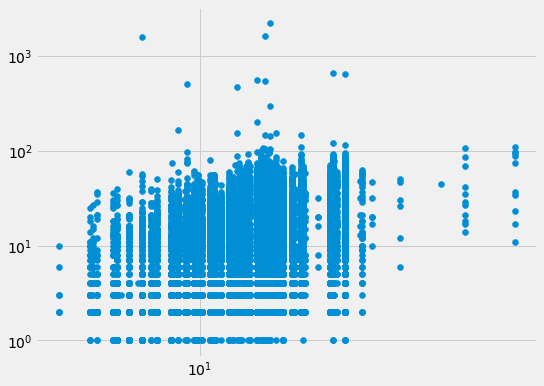

In [367]:
from matplotlib import pyplot as plt

# Because we are dealing with log in RMSLE 
# it means it also needs to be plotted with log to see the exponential difference visually in a smaller graph 

# This plot was without the holiday flag 
y_hat = model.predict(X)
plt.scatter(y_hat, y)
ax = plt.gca()
ax.loglog()

### Make an example restaurant and predict on it with genre and dow

In [374]:
# Make a look up list to plug in permutations 
list(enumerate(X.columns))

[(0, 'dow0'),
 (1, 'dow1'),
 (2, 'dow2'),
 (3, 'dow3'),
 (4, 'dow4'),
 (5, 'dow5'),
 (6, 'dow6'),
 (7, 'genre-Asian'),
 (8, 'genre-Bar-Cocktail'),
 (9, 'genre-Cafe-Sweets'),
 (10, 'genre-Creative-cuisine'),
 (11, 'genre-Dining-bar'),
 (12, 'genre-International-cuisine'),
 (13, 'genre-Italian-French'),
 (14, 'genre-Izakaya'),
 (15, 'genre-Japanese-food'),
 (16, 'genre-Karaoke-Party'),
 (17, 'genre-Okonomiyaki-Monja-Teppanyaki'),
 (18, 'genre-Other'),
 (19, 'genre-Western-food'),
 (20, 'genre-Yakiniku-Korean-food')]

In [376]:
# Look at the features - with the genre and dow columns 
example_restaurant = np.zeros(len(X.columns), dtype=np.int)
# example_restaurant[14] = 1
example_restaurant[5] = 1
model.predict(np.array([example_restaurant]))

array([14.36426138])

In [332]:
# The null hypothesis 
feature_df.reserve_visitors.mean()

13.879148508213207

### Make an example restaurant and predict on it with genre, dow, is_hol 

In [537]:
list(enumerate(X.columns))

[(0, 'dow0'),
 (1, 'dow1'),
 (2, 'dow2'),
 (3, 'dow3'),
 (4, 'dow4'),
 (5, 'dow5'),
 (6, 'dow6'),
 (7, 'genre-Asian'),
 (8, 'genre-Bar-Cocktail'),
 (9, 'genre-Cafe-Sweets'),
 (10, 'genre-Creative-cuisine'),
 (11, 'genre-Dining-bar'),
 (12, 'genre-International-cuisine'),
 (13, 'genre-Italian-French'),
 (14, 'genre-Izakaya'),
 (15, 'genre-Japanese-food'),
 (16, 'genre-Karaoke-Party'),
 (17, 'genre-Okonomiyaki-Monja-Teppanyaki'),
 (18, 'genre-Other'),
 (19, 'genre-Western-food'),
 (20, 'genre-Yakiniku-Korean-food'),
 (21, 'is_hol0.0'),
 (22, 'is_hol1.0')]

In [544]:
# Look at the features - with the genre, dow, and is_hol
example_restaurant = np.zeros(len(X.columns), dtype=np.int)
# with the type of restaurant it shows the same as day of week 4
example_restaurant[14] = 1
model.predict(np.array([example_restaurant]))

array([12.75305606])

In [2]:
# Look at the features - with the genre, dow, and is_hol
#example_restaurant = np.zeros(len(X.columns), dtype=np.int)
# with the type of restaurant it shows the same as day of week 4
#example_restaurant[17] = 1
#model.predict(np.array([example_restaurant]))

In [545]:
# Look at the features - with the genre, dow, and is_hol  
example_restaurant = np.zeros(len(X.columns), dtype=np.int)
# with the popular days we see an increase over the null hypothesis 
example_restaurant[5] = 1
model.predict(np.array([example_restaurant]))

array([14.25169446])

In [543]:
# Look at the features - with the genre, dow, and is_hol 
example_restaurant = np.zeros(len(X.columns), dtype=np.int)
example_restaurant[22] = 1
# with is_holiday true 
# -- it has a worse effect on the number of visitors going from mean 13 to 9 
model.predict(np.array([example_restaurant]))

array([9.4034156])

In [541]:
# The null hypothesis 
feature_df.reserve_visitors.mean()

13.879148508213207

In [547]:
X.columns

Index(['dow0', 'dow1', 'dow2', 'dow3', 'dow4', 'dow5', 'dow6', 'genre-Asian',
       'genre-Bar-Cocktail', 'genre-Cafe-Sweets', 'genre-Creative-cuisine',
       'genre-Dining-bar', 'genre-International-cuisine',
       'genre-Italian-French', 'genre-Izakaya', 'genre-Japanese-food',
       'genre-Karaoke-Party', 'genre-Okonomiyaki-Monja-Teppanyaki',
       'genre-Other', 'genre-Western-food', 'genre-Yakiniku-Korean-food',
       'is_hol0.0', 'is_hol1.0'],
      dtype='object')

[]

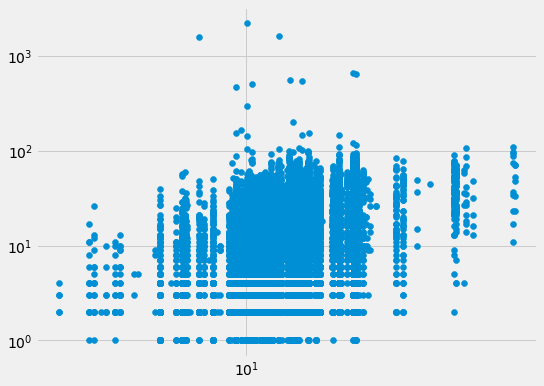

In [546]:
from matplotlib import pyplot as plt

# Because we are dealing with log in RMSLE 
# it means it also needs to be plotted with log to see the exponential difference visually in a smaller graph 

# This plot was with all the X columns above 
y_hat = model.predict(X)
plt.scatter(y_hat, y)
ax = plt.gca()
ax.loglog()

### Random Forest - with holiday flag added 

In [535]:
# Random Forest Model 
dow_cols = [c for c in feature_df.columns if c.startswith('dow')]
genre_cols = [c for c in feature_df.columns if c.startswith('genre')]
holiday_cols = [c for c in feature_df.columns if c.startswith('is_hol')]

feature_cols = dow_cols + genre_cols + holiday_cols

X = feature_df[feature_cols]
y = feature_df.reserve_visitors
model = try_fitting_rf(X, y)

pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

rmsle 0.8382072682672774


dow4                                  0.197452
dow5                                  0.185754
genre-Izakaya                         0.173906
is_hol0.0                             0.106832
genre-Karaoke-Party                   0.049480
genre-Yakiniku-Korean-food            0.045463
genre-Creative-cuisine                0.039702
dow6                                  0.032996
genre-Cafe-Sweets                     0.031486
is_hol1.0                             0.028655
genre-Dining-bar                      0.021590
dow3                                  0.015359
dow2                                  0.011365
genre-Bar-Cocktail                    0.010737
dow0                                  0.009256
genre-Western-food                    0.008854
genre-Okonomiyaki-Monja-Teppanyaki    0.007403
genre-Other                           0.007038
genre-Japanese-food                   0.005791
dow1                                  0.005584
genre-Italian-French                  0.004876
genre-Interna

### Linear Regression work continued 

In [208]:
# intercept = linreg.intercept_
#coefficient = linreg.coef_
#my_lr = linreg
#x = X

#def predict2(my_lr,x):
#    intercept = linreg.intercept_
#    coefficient = linreg.coef_
#    my_lr = linreg
#    x = X
#    return intercept + coefficient*x

# predict2(my_lr,x) # predicts for every row in dow5

In [210]:
# def predict():
#    total_base_visitors = linreg.intercept_
#    total_base_visitors = np.asarray(total_base_visitors, dtype='float64')
#    increment_base_feature = linreg.coef_
#    increment_base_feature = np.asarray(increment_base_feature, dtype='float64')
#    total_calc_visitors = (total_base_visitors + (increment_base_feature * feature))
#    return(total_calc_visitors)

### Previous Linear Regression Model work 

In [205]:
# Import, instantiate, fit.\n",
from sklearn.linear_model import LinearRegression
# Create X and y.
feature_cols = ['month12', 'dow5', 'Tōkyō-to', 'genre-Italian-French']
print(feature_cols)
X = feature_df[feature_cols]
y = feature_df.reserve_visitors

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print('Feature being fitted to reserve visitors: ', feature_cols)
print('Total base # of visitors: ', linreg.intercept_) 
# where all independent variables are 0 base value -- eg: dow0 has 14 visitors 
print('Increment of ', feature, ', expect visitor to adjust by: ',linreg.coef_)
# comparing dow0 to visitors  eg: subtract 3 visitors \n",
print('----------------------------------------------------- \n')
print(linreg.intercept_)  # where all independent variables are 0 -- if month december expect \n",
print(linreg.coef_)       # comparing dow0 to visitors  \n",
                          # - for each december add 4 visitors\n",
                          # All other day of week we show a decrease\n"


['month12', 'dow5', 'Tōkyō-to', 'genre-Italian-French']
Feature being fitted to reserve visitors:  ['month12', 'dow5', 'Tōkyō-to', 'genre-Italian-French']
Total base # of visitors:  14.15783213662352
Increment of  genre-Okonomiyaki-Monja-Teppanyaki , expect visitor to adjust by:  [ 4.16896117  4.12800049 -4.07590339 -1.02757348]
----------------------------------------------------- 

14.15783213662352
[ 4.16896117  4.12800049 -4.07590339 -1.02757348]


In [184]:
# Getting features lined up the hard way -- only way to not have it randomly do stupid associations.
# Then learned about Random Forest which mathematically is checking permutations (and relationships)


feature_cols_list = [['dow5', 'Fukuoka-ken'],
['dow5', 'Hiroshima-ken'],
['dow5', 'Hokkaidō'],
['dow5', 'Tōkyō-to'],
['dow5', 'Ōsaka-fu'],
['dow6', 'Fukuoka-ken'],
['dow6', 'Hiroshima-ken'],
['dow6', 'Hokkaidō'],
['dow6', 'Tōkyō-to'],
['dow6', 'Ōsaka-fu'],
['dow5', 'genre-Okonomiyaki-Monja-Teppanyaki'],
['dow5', 'genre-Other'],
['dow5', 'genre-Cafe-Sweets'],
['dow5', 'genre-Italian-French'],
['dow5', 'genre-Dining-bar'],
['dow6', 'genre-Okonomiyaki-Monja-Teppanyaki'],
['dow6', 'genre-Other'],
['dow6', 'genre-Cafe-Sweets'],
['dow6', 'genre-Italian-French'],
['dow6', 'genre-Dining-bar'],
['dow4', 'Fukuoka-ken', 'genre-Okonomiyaki-Monja-Teppanyaki'],
['dow4', 'Hiroshima-ken', 'genre-Other'],
['dow4', 'Hokkaidō', 'genre-Cafe-Sweets'],
['dow4', 'Tōkyō-to', 'genre-Italian-French'],
['dow4', 'Ōsaka-fu', 'genre-Dining-bar'],
['dow5', 'Fukuoka-ken', 'genre-Okonomiyaki-Monja-Teppanyaki'],
['dow5', 'Hiroshima-ken', 'genre-Other'],
['dow5', 'Hokkaidō', 'genre-Cafe-Sweets'],
['dow5', 'Tōkyō-to', 'genre-Italian-French'],
['dow5', 'Ōsaka-fu', 'genre-Dining-bar'],
['dow6', 'Fukuoka-ken', 'genre-Okonomiyaki-Monja-Teppanyaki'],
['dow6', 'Hiroshima-ken', 'genre-Other'],
['dow6', 'Hokkaidō', 'genre-Cafe-Sweets'],
['dow6', 'Tōkyō-to', 'genre-Italian-French'],
['dow6', 'Ōsaka-fu', 'genre-Dining-bar'],
['month4', 'dow5', 'Fukuoka-ken', 'genre-Okonomiyaki-Monja-Teppanyaki'],
['month4', 'dow5', 'Hiroshima-ken', 'genre-Other'],
['month4', 'dow5', 'Hokkaidō', 'genre-Cafe-Sweets'],
['month4', 'dow5', 'Tōkyō-to', 'genre-Italian-French'],
['month4', 'dow5', 'Ōsaka-fu', 'genre-Dining-bar'],
['month5', 'dow5', 'Fukuoka-ken', 'genre-Okonomiyaki-Monja-Teppanyaki'],
['month5', 'dow5', 'Hiroshima-ken', 'genre-Other'],
['month5', 'dow5', 'Hokkaidō', 'genre-Cafe-Sweets'],
['month5', 'dow5', 'Tōkyō-to', 'genre-Italian-French'],
['month5', 'dow5', 'Ōsaka-fu', 'genre-Dining-bar'],
['month11', 'dow5', 'Fukuoka-ken', 'genre-Okonomiyaki-Monja-Teppanyaki'],
['month11', 'dow5', 'Hiroshima-ken', 'genre-Other'],
['month11', 'dow5', 'Hokkaidō', 'genre-Cafe-Sweets'],
['month11', 'dow5', 'Tōkyō-to', 'genre-Italian-French'],
['month11', 'dow5', 'Ōsaka-fu', 'genre-Dining-bar'],
['month12', 'dow5', 'Fukuoka-ken', 'genre-Okonomiyaki-Monja-Teppanyaki'],
['month12', 'dow5', 'Hiroshima-ken', 'genre-Other'],
['month12', 'dow5', 'Hokkaidō', 'genre-Cafe-Sweets'],
['month12', 'dow5', 'Tōkyō-to', 'genre-Italian-French'],
['month12', 'dow5', 'Ōsaka-fu', 'genre-Dining-bar']]

type(feature_cols_list)

list

In [188]:
# Import, instantiate, fit.\n",
from sklearn.linear_model import LinearRegression

# Tested with : feature_cols_list = [['dow5', 'Fukuoka-ken'],['dow5', 'Hiroshima-ken']]

# Create X and y.

for pair in feature_cols_list:
    X = feature_df[pair]
    y = feature_df.reserve_visitors
    # Instantiate and fit.
    linreg = LinearRegression()
    linreg.fit(X, y)

# Print the coefficients.
    print('----------------------------------------------------- \n')
    print('Feature being fitted to reserve visitors: ', pair)
    print('Total base # of visitors at intercept: ', linreg.intercept_) 
# where all independent variables are 0 base value -- eg: dow0 has 14 visitors 
    print('Increment of coeff ', pair, ', expect visitor(s) to adjust by: ',linreg.coef_)
# comparing dow0 to visitors  eg: subtract 3 visitors \n",
    #print(linreg.intercept_)  # where all independent variables are 0 -- if month december expect \n",
    #print(linreg.coef_)       # comparing dow0 to visitors  \n",
                          # - for each december add 4 visitors\n",
                          # All other day of week we show a decrease\n"
    #print('----------------------------------------------------- \n')

----------------------------------------------------- 

Feature being fitted to reserve visitors:  ['dow5', 'Fukuoka-ken']
Total base # of visitors at intercept:  13.092204282518054
Increment of coeff  ['dow5', 'Fukuoka-ken'] , expect visitor(s) to adjust by:  [4.25407876 0.20992205]
----------------------------------------------------- 

Feature being fitted to reserve visitors:  ['dow5', 'Hiroshima-ken']
Total base # of visitors at intercept:  12.858771117143519
Increment of coeff  ['dow5', 'Hiroshima-ken'] , expect visitor(s) to adjust by:  [4.22610603 3.27196626]
----------------------------------------------------- 

Feature being fitted to reserve visitors:  ['dow5', 'Hokkaidō']
Total base # of visitors at intercept:  12.916468327900152
Increment of coeff  ['dow5', 'Hokkaidō'] , expect visitor(s) to adjust by:  [4.23849423 1.72185867]
----------------------------------------------------- 

Feature being fitted to reserve visitors:  ['dow5', 'Tōkyō-to']
Total base # of visitors at

### Set index to air_store_id for merge of reservations with the store relation data set 

This was not needed, nor useful for HPG. 

Left it to show the work done. 

In [219]:
sid_rel_df = sid_rel_df.set_index('air_store_id')
sid_rel_df.head(1)

,hpg_store_id
air_store_id,
air_63b13c56b7201bd9,hpg_4bc649e72e2a239a


In [385]:
feature_df.shape

(29830, 55)

In [223]:
sample_df.id.str.startswith('air').all()

True

### Merging air reservations and hpg reservations based on store relation

Turns out it isn't needed and doesn't help. 
Left to show the work was done 

In [235]:
hpg_resv_rel_merge = pd.merge(hpgres_df, sid_rel_df, how='left', on=['hpg_store_id'])
hpg_resv_rel_merge.head(3)

# most are Nan -- one is air_290e7a57b390f78e

,hpg_store_id,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 14:00:00,2


In [251]:
#air_resv_rel_merge = pd.merge(ar_df, sid_rel_df, on=['air_store_id'])
#air_resv_rel_merge.head(3)

print(ar_df.head())
print(hpgres_df.head())
#sid_rel_df.head()

                             air_store_id    reserve_datetime reserve_visitors
visit_datetime                                                                
2016-01-01 19:00:00  air_877f79706adbfb06 2016-01-01 16:00:00                1
2016-01-01 19:00:00  air_db4b38ebe7a7ceff 2016-01-01 19:00:00                3
2016-01-01 19:00:00  air_db4b38ebe7a7ceff 2016-01-01 19:00:00                6
2016-01-01 20:00:00  air_877f79706adbfb06 2016-01-01 16:00:00                2
2016-01-01 20:00:00  air_db80363d35f10926 2016-01-01 01:00:00                5
                             hpg_store_id    reserve_datetime reserve_visitors
visit_datetime                                                                
2016-01-01 11:00:00  hpg_c63f6f42e088e50f 2016-01-01 09:00:00                1
2016-01-01 13:00:00  hpg_dac72789163a3f47 2016-01-01 06:00:00                3
2016-01-01 16:00:00  hpg_c8e24dcf51ca1eb5 2016-01-01 14:00:00                2
2016-01-01 17:00:00  hpg_24bb207e5fd49d4a 2016-01-01

In [234]:
# Inner join is closer yet still whacked for numbers -- 3583374
merged = pd.merge(hpg_resv_rel_merge,air_resv_rel_merge, how='inner', on=['air_store_id'])

In [ ]:
merged.shape

In [232]:
merged.to_csv('./both-reservation-data-merged-after-store-rel-merge-inner.csv')

In [ ]:
# Outer join 
# merged.to_csv('./both-reservation-data-merged-after-store-rel-merge-outer.csv')
# 
# this is too big at 11,621,476-- it should be combined the shape of 2,092,698 = ( 92378 + 2000320)

In [231]:
air_resv_rel_merge.columns

In [ ]:
# Air Null mask looking for Nan hpg_store_id 
air_res_null_mask = air_resv_rel_merge['hpg_store_id'].isnull()
air_resv_rel_merge[air_res_null_mask].shape

In [ ]:
# Air Not Null mask looking for filled in hpg_store_id
air_res_not_null_mask = air_resv_rel_merge['hpg_store_id'].notnull()
air_resv_rel_merge[air_res_not_null_mask].shape

# 92378 = 36264 + 56114

In [ ]:
air_resv_rel_merge.shape
#   92379 air_reserve.csv
# 2000321 hpg_reserve.csv

In [ ]:
ar_df.head()

In [ ]:
hpg_resv_rel_merge.shape
#   92379 air_reserve.csv
# 2000321 hpg_reserve.csv

In [ ]:
hpgresorig_df.shape

In [254]:
## hpg_resv_rel_merge.air_store_id
## hpg_resv_rel_merge['air_store_id']
## hpg_resv_rel_merge[hpg_resv_rel_merge['air_store_id'] == 'NaN']

#hpg_res_null_mask = hpg_resv_rel_merge['air_store_id'].isnull()
#hpg_resv_rel_merge[hpg_res_null_mask].head()

In [ ]:
# Null         1972137
# not NULL       28183
# Total 
# reservations 2000320
hpg_resv_rel_merge[hpg_res_null_mask].shape

In [ ]:
hpg_res_not_null_mask = hpg_resv_rel_merge['air_store_id'].notnull()
hpg_resv_rel_merge[hpg_res_not_null_mask].shape

### First tests of adding reservation data sets for their respective data 

Columns for air store: air_store_id,air_genre_name,air_area_name,latitude,longitude

Columns for hpg store: hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude

In [ ]:
# hpg_resv_rel_merge = pd.merge(hpgres_df, sid_rel_df, how='left', on=['hpg_store_id'])
hpg_resv_rel_merge.head(3)

# air_resv_rel_merge = pd.merge(ar_df, sid_rel_df, how='left', on=['air_store_id'])
air_resv_rel_merge.head(3)

test_hpg_resv_rel_merge = pd.merge(hpg_resv_rel_merge, hpgsi_df, how='left', on=['hpg_store_id'])

test_air_resv_rel_merge = pd.merge(air_resv_rel_merge, asi_df, how='left', on=['air_store_id'])

## <a id="add-date-diff-to-reservations"></a>
## Notes on Add date diffs to reservation data 

Work on Air Reservations along with the HPG reservations 

#### Original idea looked like the following
#### date, total_visitors, locations (store_id), system(yelp or reservation)

I realized that I'd need to break out the dummy variables in a way to be able to see a distribution curve over time. 

And reservation data time diffs wasn't what I wanted to use to help predict 

### <a id="air-store-info"></a>
### Air Store Info (ASI)

This file contains information about select air restaurants. Column names and contents are self-explanatory.

* air_store_id
* air_genre_name
* air_area_name
* latitude
* longitude

Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

In [ ]:
# Air Store Info (asi)  
print('The ASI data types are: \n')
print(asi_df.dtypes)
print('\n')
print('The index for Air Store Info is: \n')
print(asi_df.index)
print('\n')
print('The ASI data frame info shows no nulls because the counts across all rows are same: \n')
print(asi_df.info())
print('\n')
print('----------- Air Store Info First rows  \n')
print(asi_df.head(3))

In [ ]:
# Noting that the air_store_id does not appear to match up in the store_id_relation data at all 
# asi_df['air_store_id'].value_counts().head(3)

In [ ]:
# Would like to compare hpgsi_df area name to asi_df area name to see what matches or overalaps if any 
# asi_df['air_area_name'].value_counts().head(20)

In [ ]:
# Looking at the distribution of Genre to get an idea of classification 
# Air Store Info for Genre are completely different than HPG Store Info by Genre 
# First pass is to look and gauge without renaming 
# asi_df['air_genre_name'].value_counts()

# Questions that arise from EDA looking at the data 
# How to reduce the Genre info into human readable names across both (or not) ? 

#####################################
# Scme context on names: 
#####################################
# Izakaya = pub                   197
# Cafe/Sweets                     181
# Dining bar                      108
# Italian/French                  102
# Bar/Cocktail                     79
# Japanese food                    63
# Other                            27
# Yakiniku = bbq /Korean food      23
# Western food                     16
# Okonomiyaki/Monja/Teppanyaki = savory_pancakes    14
# Creative cuisine                 13
# Karaoke/Party                     2
# Asian                             2
# International cuisine             2
# Name: air_genre_name, dtype: int64

### <a id="air-reservation-data"></a>
### Air Reservation Data (AR)

Data contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

* air_store_id - the restaurant's id in the air system
* visit_datetime - the time of the reservation
* reserve_datetime - the time the reservation was made
* reserve_visitors - the number of visitors for that reservation

In [ ]:
# Air Reserve Data (ar) loaded for datetime columns 
print('The AR data types are: \n')
print(ar_df.dtypes)
print('\n')
print('The AR index for air reserve data is based around time from January 2016 to end of May 2017: \n')
print(ar_df.index)
print('\n')
print('The AR data frame info shows no nulls because the counts across all rows are same: \n')
print(ar_df.info())
print('\n')
print('----------- Air Reserve Data First rows  \n')
print(ar_df.head(3))

### <a id="date-info-data"></a>
### Date Info (date_info)

Loaded data with datetime index and rangeindex to be able to work with data in different ways 

This file gives basic information about the calendar dates in the dataset.

* calendar_date
* day_of_week
* holiday_flg - is the day a holiday in Japan

Normally these columns below would have to be made into features and appended to the data set 
We have a gap in data, not in our lookup table

* In this case the date info date ranges are full from January 1st 2016 to May 31st 2017 
* Note that the Air Visit Data is from January 13th 2016 to April 22nd 2017 ; which doesn't match Air Reserve Data 

In [ ]:
## date_info_df['year'] = date_info_df.index.year
## date_info_df['month'] = date_info_df.index.month
## date_info_df['dow'] = date_info_df.index.dayofweek

In [170]:
print(date_info_df.tail())

              day_of_week  holiday_flg
calendar_date                         
2017-05-27       Saturday            0
2017-05-28         Sunday            0
2017-05-29         Monday            0
2017-05-30        Tuesday            0
2017-05-31      Wednesday            0


In [175]:
# Didn't end up using as it would mean units would not be uniform 
# wkend_holidays = date_info_range_df.apply(lambda x: (x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1, axis=1)
# date_info_range_df.loc[wkend_holidays, 'holiday_flg'] = 0
# date_info_range_df['weight'] = ((date_info_range_df.index + 1) / len(date_info_range_df)) ** 5  

In [ ]:
type(date_info_df.index)

In [ ]:
wkend_holidays.value_counts()

In [470]:
# This is all our holiday data 
# It doesn't have a big affect -- it actually pulls down the values. 
# Unless a special holiday were found there are less visitors on holidays 
date_info_df[date_info_df.holiday_flg >= 1].head()
date_info_df.holiday_flg.value_counts()

0    482
1     35
Name: holiday_flg, dtype: int64

### <a id="store-id-relation-between-air-hpg"></a>
### Store Id Relation (sid_rel) between some joint air/hpg systems 

This file of 151 records allows you to join select restaurants that have both the air and hpg system.

The stores though are not unique to the air visit data data set that I found. 

HPG doesn't have mapping to any of it's air id's because most do not exist. 

* hpg_store_id (expect these not to be in air_visit_data data set)
* air_store_id (not all air stores are in the visits) 


In [ ]:
print('The Store Id Relation (sid_rel) data types are: \n')
print(sid_rel_df.dtypes)
print('\n')
print('The index for Store Id Relation (sid_rel) data is based around time from January 2016 to end of May 2017: \n')
print(sid_rel_df.index)
print('\n')
print('The sid_rel data frame info shows no nulls because the counts across all rows are same: \n')
print(sid_rel_df.info())
print('\n')
print('----------- Air Store Id Relationship to HPG Reserve Id First rows  \n')

In [ ]:
# This is a combo look up table 
# what to call it for a dummy variable -- can I make it a feature? 
sid_rel_df.head(3)

In [ ]:
sid_rel_df['air_store_id'].value_counts().head()

In [ ]:
sid_rel_df['hpg_store_id'].value_counts().head()

### <a id="hpg-store-info"></a>
### HPG Store Info (hpgsi)

This file contains information about select hpg restaurants. Column names and contents are self-explanatory.

* hpg_store_id
* hpg_genre_name
* hpg_area_name
* latitude
* longitude

Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

In [ ]:
# HPG Store Info Data (ar) loaded for datetime columns 
print('The HPG Store Info data types are: \n')
print(hpgsi_df.dtypes)
print('\n')
print('The index for HPG Store Info data: \n')
print(hpgsi_df.index)
print('\n')
print('The HPG Store Info data frame info shows no nulls because the counts across all rows are same: \n')
print(hpgsi_df.info())
print('\n')
print('----------- HPG Store Info Data First rows  \n')
print(hpgsi_df.head())

# Figures genre is different across systems hpg genre is different than air genre 
print(hpgsi_df['hpg_genre_name'].value_counts().head(20))
# This might lead to the most popular areas for visitors - will have to be compared to by air 
# This has to be broken out by ward, chu, kome to really be userful... 
# The None's will throw off the straight comparison 
hpgsi_df['hpg_area_name'].value_counts().head(20)

### <a id="hpg-reservation-data"></a>
### HPG Reserve (hpgres) Data 

This file contains reservations made in the hpg system.

* hpg_store_id - the restaurant's id in the hpg system
* visit_datetime - the time of the reservation
* reserve_datetime - the time the reservation was made
* reserve_visitors - the number of visitors for that reservation

In [ ]:
# HPG Reservation Data (hpgres) 
print('The HPG Reservation data types are: \n')
print(hpgres_df.dtypes)
print('\n')
print('The HPG Reservation Data index is based on time from January 1st 2016 to May 31st 2017: \n')
print(hpgres_df.index)
print('\n')
print('The HPG Reservation data frame info shows no nulls because all the counts across rows are the same: \n')
print(hpgres_df.info())
print('\n')
print('----------- HPG Reservation Data First rows  \n')
print(hpgres_df.head(3))
print('\n')
print('----------- HPG Reservation Data Last rows  \n')
print(hpgres_df.tail(3))

## <a id="linear-regression-fit2"></a>
## Linear Regression fit of features 

In [306]:
print(feature_cols)

['dow5']


In [307]:
# Pair the feature names with the coefficients.
list(zip(feature_cols, linreg.coef_))

[('dow5', 4.25616092240907)]

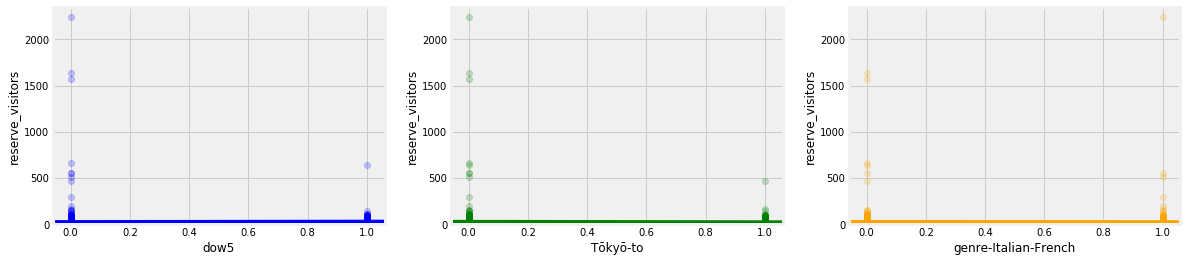

In [214]:
# These were just not helpful as much as I could do to try... and I did try. 
# If you have any ideas... these were not as helpful 
# as the numbers that told me what went up/down in response to permutations 

c = ['blue', 'green','orange']
fig, axs = plt.subplots(ncols=3,figsize=(18,4))

for x, var in enumerate(['dow5', 'Tōkyō-to', 'genre-Italian-French']):
    linmodel = sns.regplot(feature_df[var], feature_df['reserve_visitors'], ax = axs[x], color=c[x],scatter_kws={'alpha':0.2})
    linmodel.set(ylim=(0, None))


### Correllations 

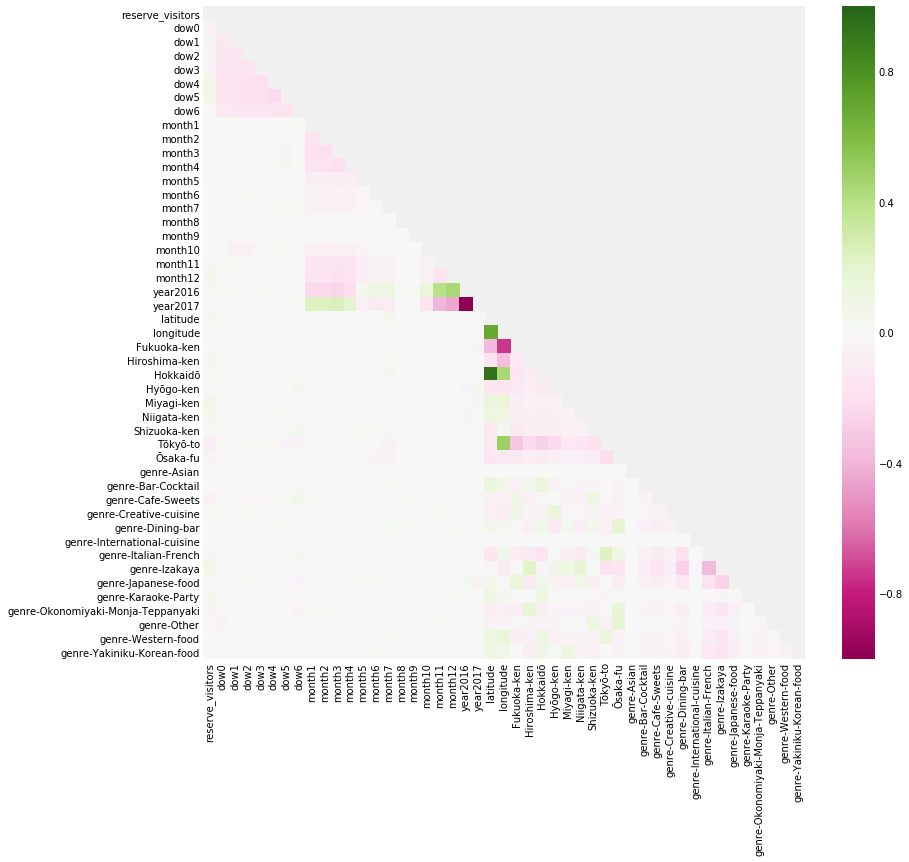

In [211]:
# Correllations also showed me that there were groups and not across the board relationships 
# I wanted to be able to iterate through permutations of features made from the dummy variables. 

# diverging scale 
# https://gist.github.com/rddunlap23/02d4014907ffaf9cbdf49f4004f82ba6 

# Make the correllation a variable 
corrs = feature_df.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(12,12))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask, cmap='PiYG')

### Linear Regression of 2 features 


In [282]:
# Pair the feature names with the coefficients. See what goes up from base # - depending on the feature. 
list(zip(lr_feature_cols, linreg.coef_))

[('dow5', 4.25616092240907)]

In [312]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()  # note the instantiation as an object 
type(lr)

lr_feature_cols = ['dow5','genre-Izakaya']

# Create X and y.
X = feature_df[lr_feature_cols]
y = feature_df.reserve_visitors

# Fit linear regression model to 4 features and the predictor y 
lr.fit(X, y)

# These are all the predictors (using 2 features/X's)
y_preds = lr.predict(X)


In [313]:
# Did not need to add y_preds back to data frame 
# avd_df['y_preds'] = y_preds

print(y_preds)

[11.82867521 11.82867521 11.82867521 ... 11.82867521 16.11911459
 11.82867521]


### Plotting the predictions (needs the y_preds in the data frame)

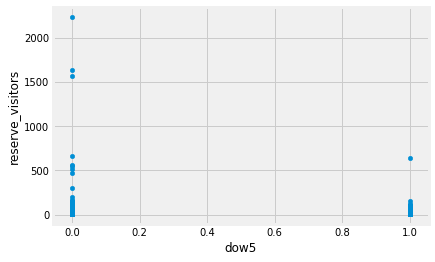

In [286]:
## Fitted from above 
feature_df.plot(kind='scatter',x='dow5',y='reserve_visitors');
## y_preds is the list of predicting against 2 features above added to the dataframe 

x = np.linspace(*ax.get_xlim())
ax.plot(x,x)
plt.show()

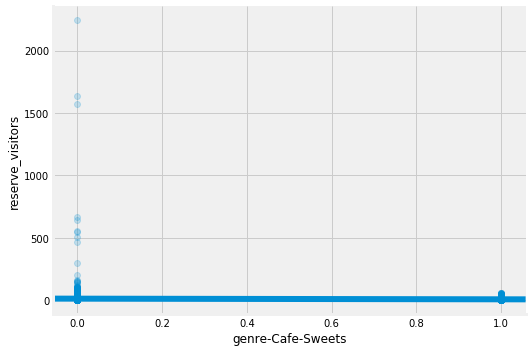

In [315]:
# Seaborn scatterplot with regression line
sns.lmplot(x='genre-Cafe-Sweets', y='reserve_visitors', data=feature_df, aspect=1.5, scatter_kws={'alpha':0.2});

In [ ]:
## Fitted from above 
feature_df.plot(kind='scatter',x='dow5',y='reserve_visitors');
## y_preds is the list of predicting against 2 features above added to the dataframe 

x = np.linspace(*ax.get_xlim())
ax.plot(x,x)
plt.show()

## <a id="2-log-or-2logp-eval"></a>
## Playing around with np log 

Did not end up having enough time to go into this more in depth. 

Issues with notebook freezing up on startup meant I had to rebuild the entire notebook from a copy 

In [273]:
print(np.log1p(feature_df.reserve_visitors).head(3))
print(np.log1p(avd_df.visitors).head(3))

0    1.098612
1    2.302585
2    2.944439
Name: reserve_visitors, dtype: float64
visit_date
2016-01-13    3.258097
2016-01-14    3.496508
2016-01-15    3.401197
Name: visitors, dtype: float64


## <a id="regression-eval"></a>
## Linear Regression eval Null RMSE, RMSLE

#### Comparing Testing RMSLE With Null RMSE

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. 
It is a benchmark against which folks may want to measure 

I compared it to RMSLE to show that the log reduced the number so that it showed orders of magnitude not the number itself. 

With so many features RMSE would have been closer to infinity versus 0 
Making is exponential means it reduces the scale to visually see the break out better 

To me it is kind of like what plotting dummy variables does to be able to put them in a range of 1 to -1 around the 0 (Sigmoid) 


In [295]:
### This was initially really just to verify that RMSE would have never shown it would get to 0 

# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create a NumPy array with the same shape as y_test.
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_test.
y_null.fill(y_test.mean())
y_null

# Compute null RMSE.
print('Null RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_null)))

# Computer RMSLE -- reduced the level of error back to better visual range 
print ('RMSLE: ',rmsle(y, y_preds))

Null RMSE:  36.92630693734815
RMSLE:  0.8777157412585951


<a id="visualizing-the-data"></a>
## Visualizing the Data

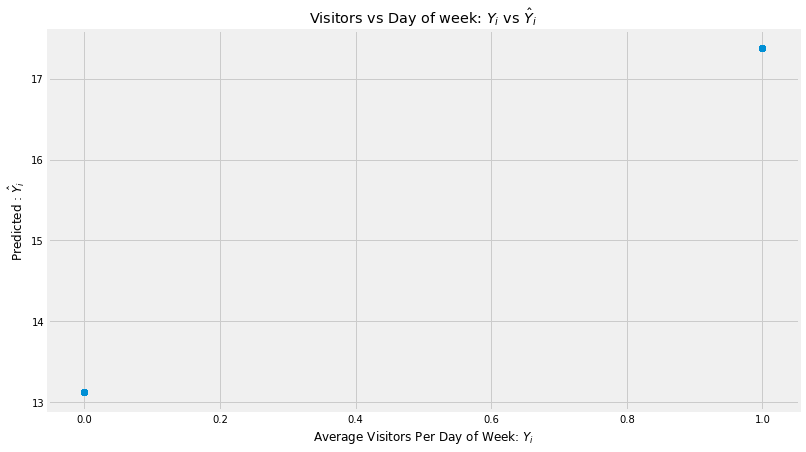

In [297]:
# Bummed I didn't get to use this -- putting in anyhoo 
plt.figure(figsize=(12,7))
plt.scatter(feature_df['dow5'], y_preds)
plt.xlabel("Average Visitors Per Day of Week: $Y_i$")
plt.ylabel("Predicted : $\hat{Y}_i$")
plt.title("Visitors vs Day of week: $Y_i$ vs $\hat{Y}_i$");

In [556]:
y_preds

array([11.82867521, 11.82867521, 11.82867521, ..., 11.82867521,
       16.11911459, 11.82867521])

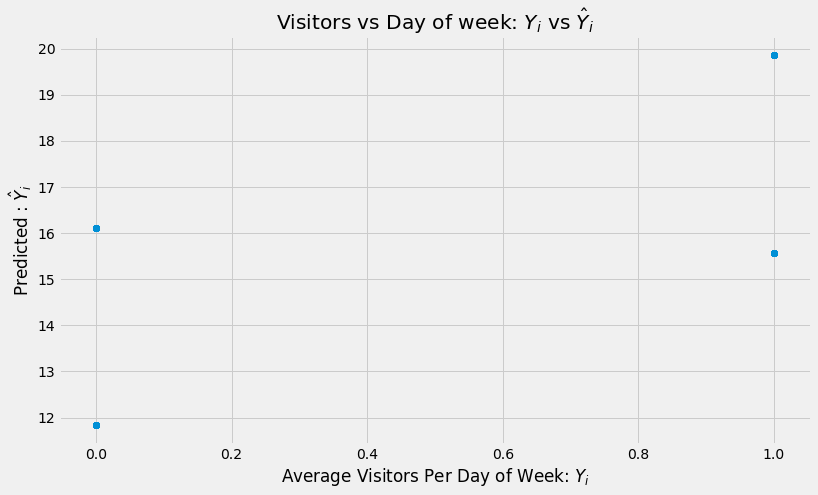

In [559]:
# Ah well, it did not give me what I thought it would. 
plt.figure(figsize=(12,7))
plt.scatter(feature_df['genre-Izakaya'], y_preds)
plt.xlabel("Average Visitors Per Day of Week: $Y_i$")
plt.ylabel("Predicted : $\hat{Y}_i$")
plt.title("Visitors vs Day of week: $Y_i$ vs $\hat{Y}_i$");

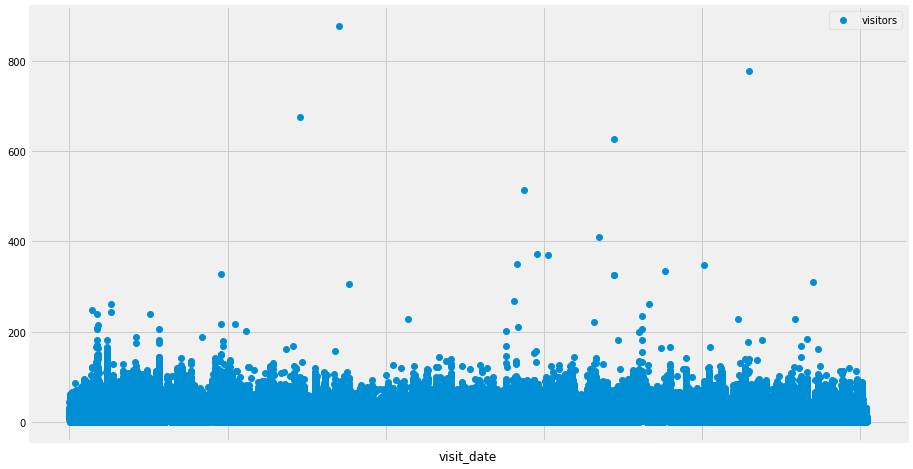

In [279]:
# This plot doesn't work with the datetime set -- only if visit date is an object 
# The outliers are mostly above 200 
avdorig_df.plot(x='visit_date', y='visitors', style='o',figsize=(14,8));

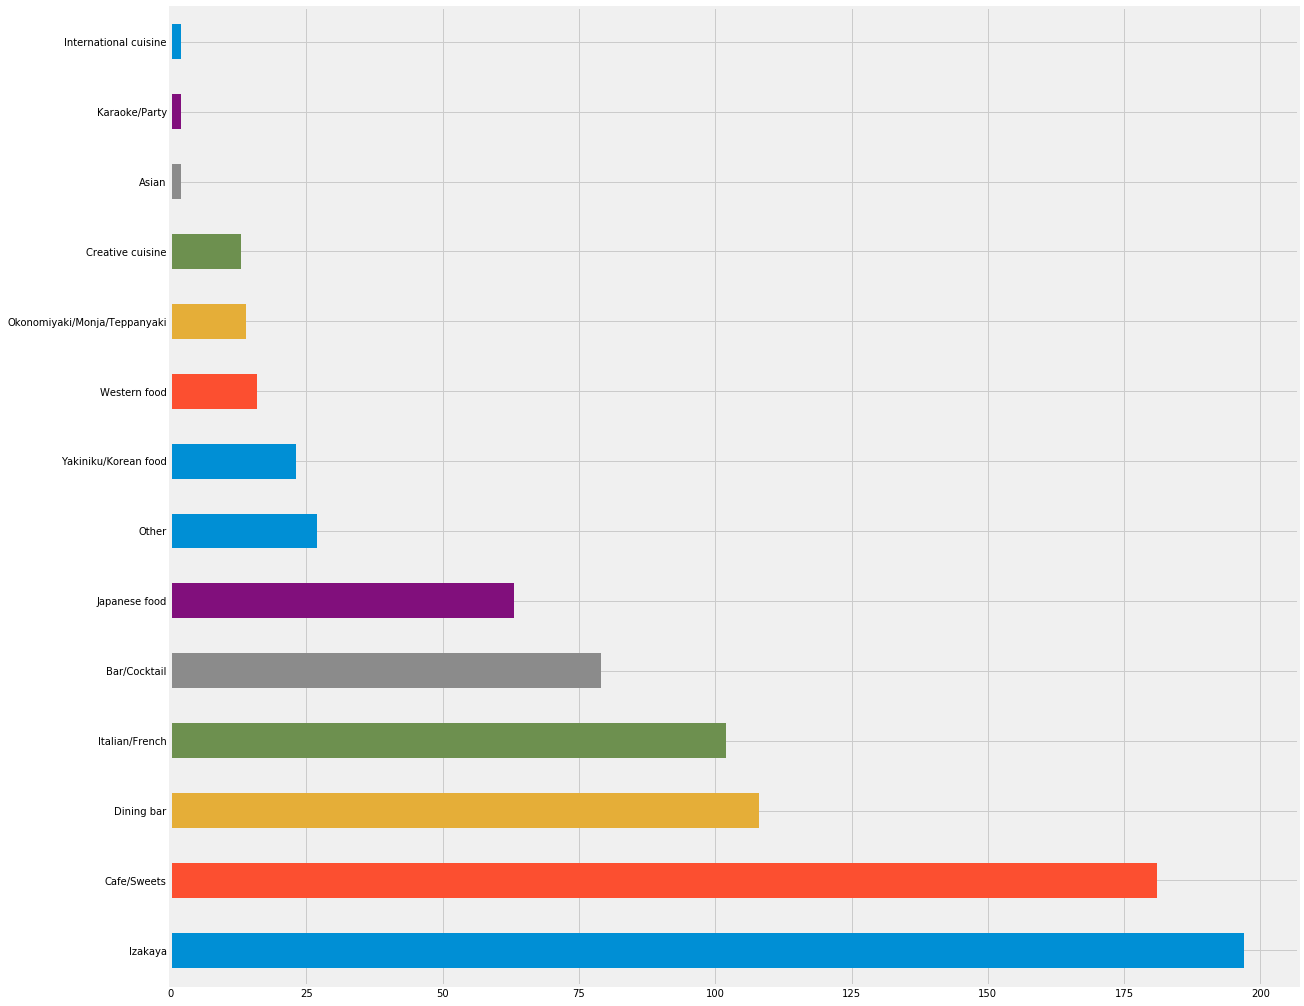

In [311]:
# Plots of Air Store info by Genre 
# The most popular type of air store is Izakaya 
asi_df['air_genre_name'].value_counts().plot(kind='barh', figsize=(18,18));


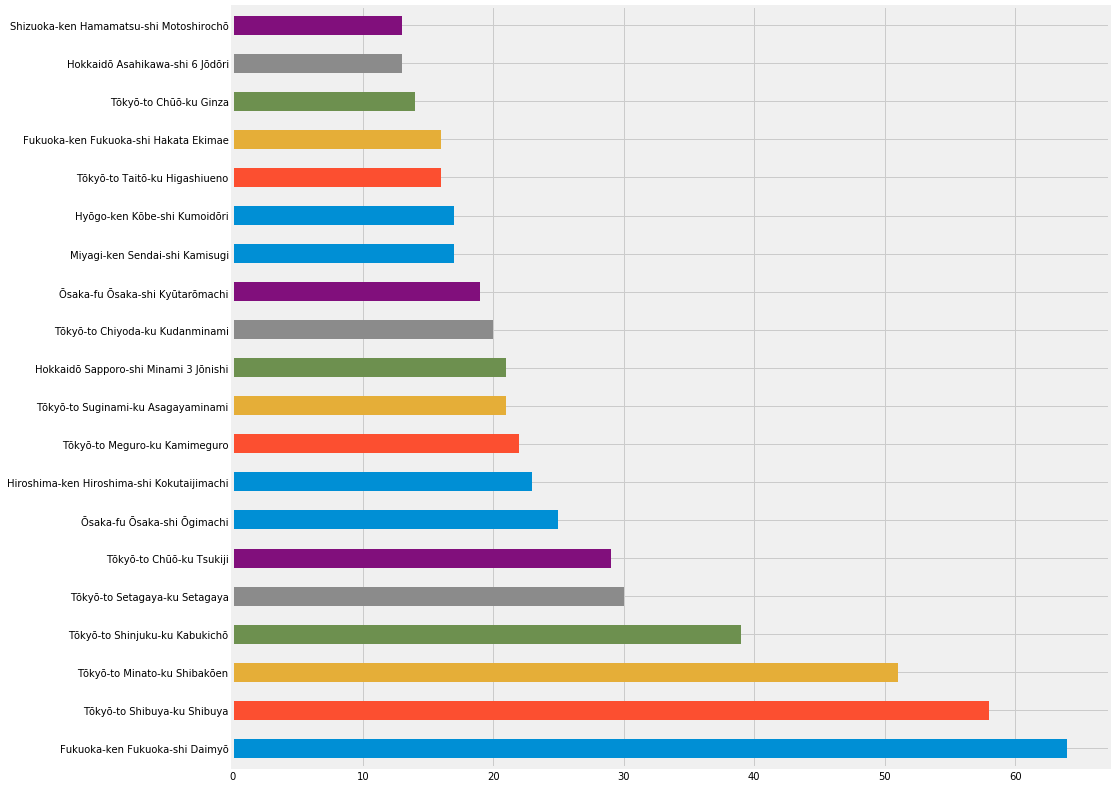

In [278]:
# Top 20 Air Store Info Areas 
# The area with the most stores is Fukuoka-ken Fukuoka-shi Daimyō at 64 
asi_df['air_area_name'].value_counts().head(20).plot(kind='barh', figsize=(14,14));

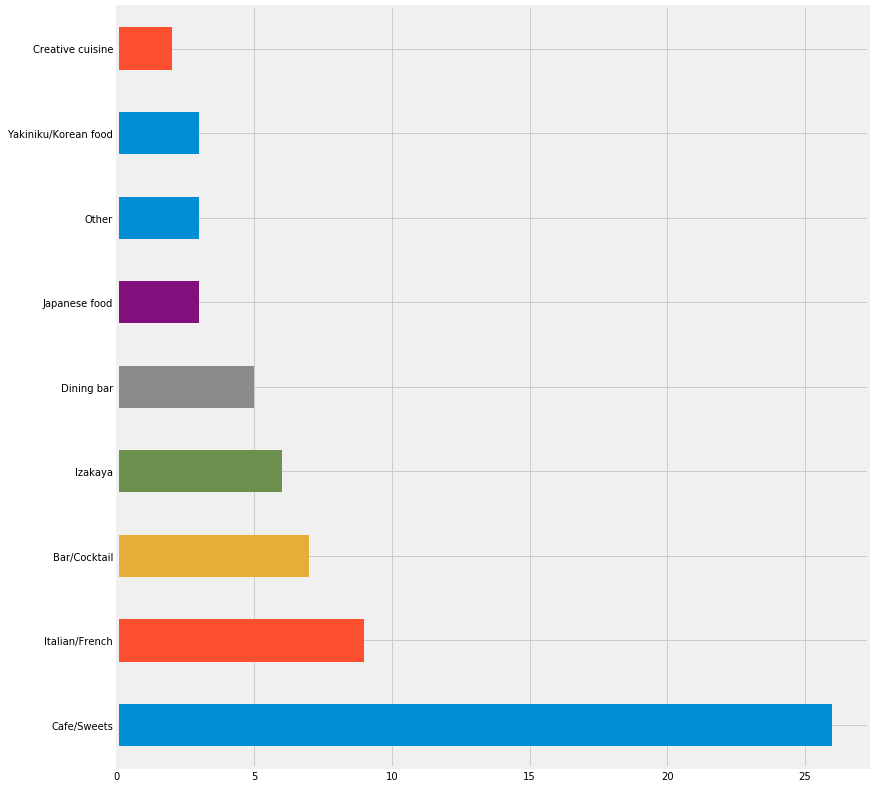

In [277]:
# In the Fukuoka-ken Fukuoka-shi Daimyō area with the most Air stores mostly has Cafe/Sweets
asi_ward_df['air_genre_name'].value_counts().plot(kind='barh', figsize=(12,14));

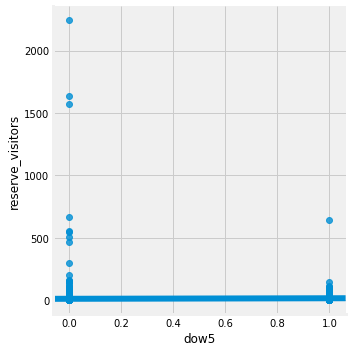

In [299]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

sns.lmplot(x='dow5', y='reserve_visitors', data=feature_df)
plt.show()

#sns.lmplot(x='dow6', y='reserve_visitors', data=feature_df)
#plt.show()

#sns.lmplot(x='month11', y='reserve_visitors', data=feature_df)
#plt.show()

#sns.lmplot(x='month12', y='reserve_visitors', data=feature_df)
#plt.show()

#sns.lmplot(x='month5', y='reserve_visitors', data=feature_df)
#plt.show()

#sns.lmplot(x='year2016', y='reserve_visitors', data=feature_df)
#plt.show()

#sns.lmplot(x='year2017', y='reserve_visitors', data=feature_df)
#plt.show()

### Air Visitor Data 

In [474]:
avd_df.index.year.value_counts()
# cmd line checks with grep and wc -l back the #'s up 

2016    174535
2017     77573
Name: visit_date, dtype: int64

In [ ]:
avd_df['air_store_id'].value_counts().head(3)

In [ ]:
# This plot was a big indicator that there would be too much fluctation and noise 

### Air Store Info 

In [472]:
asi_areas = asi_df['air_area_name']
asi_areas.head(2)

0    Hyōgo-ken Kōbe-shi Kumoidōri
1    Hyōgo-ken Kōbe-shi Kumoidōri
Name: air_area_name, dtype: object

In [473]:
asi_areas.describe()

count                                829
unique                               103
top       Fukuoka-ken Fukuoka-shi Daimyō
freq                                  64
Name: air_area_name, dtype: object

In [ ]:
# This was done elsewhere as part of the feature_df work -- this is where it was conceptually tested out 
import re 

areas_df = asi_areas

asi_ken= []
asi_ku = []
asi_chome = []

for area in areas_df:
    # print(area)
    # Split on spaces 
    split_areas = area.split(' ')
    # print(split_areas[0])
    asi_ken.append(split_areas[0])
    asi_ku.append(split_areas[1])
    asi_chome.append(split_areas[2])
print(len(asi_chome))
# print((asi_chome))

In [276]:
# The largest number of stores are in this area and their genres are diverse 
asi_ward_df = asi_df[asi_df['air_area_name'].str.contains("Fukuoka-ken Fukuoka-shi Daimyō")]
asi_ward_df.head(2)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
17,air_4579cb0669fd411b,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813
18,air_63a750d8b4b6a976,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813


### HPG Store Info Data 

In [ ]:
hpgsi_df.columns

In [ ]:
hpgsi_areas = hpgsi_df['hpg_area_name']
hpgsi_areas.head(2)

In [ ]:
hpgsi_areas.describe()

In [ ]:
# Plots of HPG Store Info Data by Genre 
# The most popular HPG store Genre is Japanese Style 
hpgsi_df['hpg_genre_name'].value_counts().plot(kind='barh', figsize=(18,18));

In [ ]:
hpgsi_df['hpg_area_name'].value_counts().head(20).plot(kind='barh', figsize=(18,18));

In [ ]:
# Reference: https://en.wikipedia.org/wiki/Wards_of_Japan
# Reference: https://en.wikipedia.org/wiki/Japanese_addressing_system 

# the 0 position - 1st entry becomes the ward list 
# the 1 position - 2nd entry becomes the ku list 
# the 2 position - 3rd entry becomes the chome 
import re 

areas_df = hpgsi_areas


hpg_ken= []
hpg_ku = []
hpg_chome = []

for area in areas_df:
    # print(area)
    # Split on spaces 
    split_areas = area.split(' ')
    # print(split_areas[0])
    hpg_ken.append(split_areas[0])
    hpg_ku.append(split_areas[1])
    hpg_chome.append(split_areas[2])
print(len(hpg_chome))
#print((hpg_chome))
    